# Integral Analysis of GRB 230307A: Split in two

Let's split the INTEGRAL data in two, so that I can search the first and second halves separately.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-10-27 08:43:00,051]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1698388980.051270       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-27 08:43:00,052]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-27 08:43:00,059]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = get_max_posterior_parameters(res)

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(tgrid)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

In [3]:
datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

barytime = np.array(data["barytime"], dtype=float)
minind = barytime.searchsorted(0.0)
maxind = barytime.searchsorted(60.0)

counts = np.array(data["counts"], dtype=float)

barytime = barytime[minind:maxind]
counts = counts[minind:maxind]

In [4]:
mean_bkg = np.mean(counts[-100:])

In [5]:
lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-27 08:43:08,865]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-27 08:43:08,961]: Checking if light curve is sorted.
INFO[2023-10-27 08:43:09,072]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


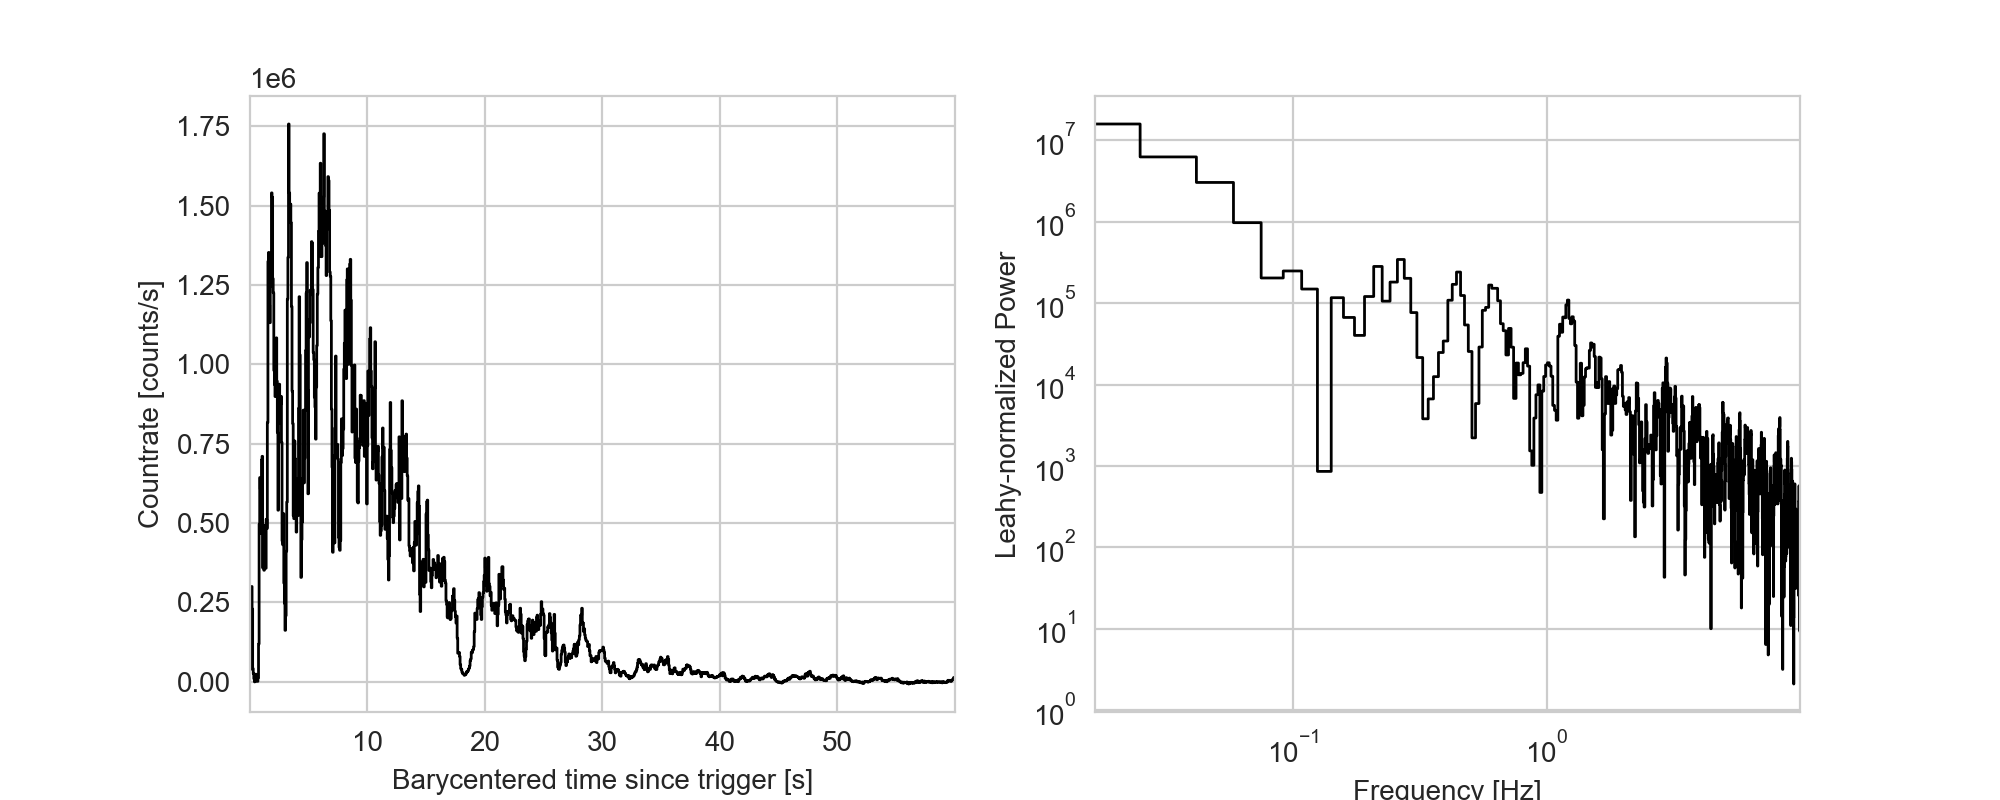

Text(0, 0.5, 'Leahy-normalized Power')

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [7]:
split_idx1 = lc.time.searchsorted(18.0)
split_idx2 = lc.time.searchsorted(19.0)

lc1 = lc.truncate(start=0, stop=split_idx1)
lc2 = lc.truncate(start=split_idx2, stop=len(lc.time))

<IPython.core.display.Javascript object>


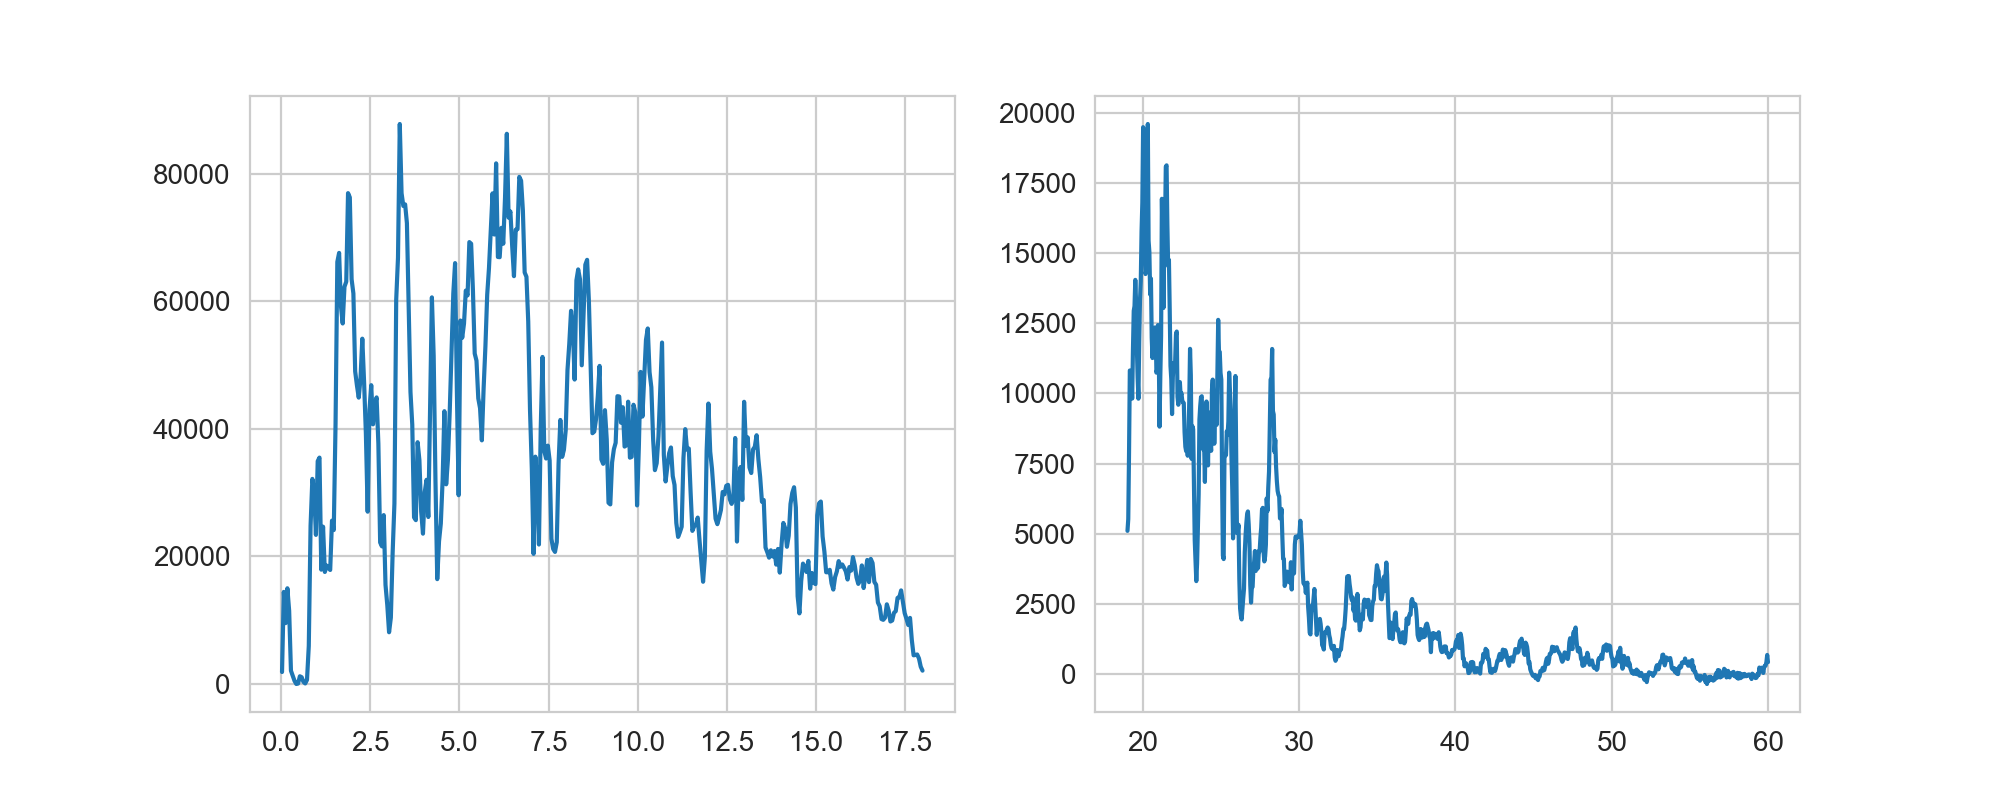

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(lc1.time, lc1.counts)
ax2.plot(lc2.time, lc2.counts)


## Gaussian Process Analysis on the first segment

Let's do the GP Analysis on the first segment. We start by comparing a Damped Random Walk with a QPO model:

In [9]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [10]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc1.time, counts = lc1.counts)

In [11]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc1)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

INFO[2023-10-27 08:46:30,033]: Sanity check...
INFO[2023-10-27 08:46:30,793]: Sanity check passed


Simulation Complete


In [12]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -3718.2518728470254


In [13]:
### SAVE THE POSTERIOR
with open(datadir+"intregal_drw_lc1_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)
    
res_rn = gpresult_rn.results

In [ ]:
### LOAD THE POSTERIOR
with open(datadir+"intregal_drw_lc1_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [14]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 3504588
# samples: 34500
# slices: 513000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 101.6
# likelihood evals / slice: 6.8
--------
logZ=-3718.252 +- 0.095
H=3700.0
ESS=8490
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.54 +- 0.85 | 10.31 / 10.75 / 10.93 | 10.85 | 10.85
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 19.6 +- 0.72 | 19.04 / 19.42 / 20.31 | 18.95 | 18.95
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.54 +- 0.74 | -0.21 / 0.72 / 1.12 | 1.16 | 1.16
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: 1.7 +- 0.77 | 0.87 / 1.59 / 2.87 | -0.01 | -0.01
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.06 +- 0.52 | 1.47 / 2.0 / 2.63 | 2.3

<IPython.core.display.Javascript object>


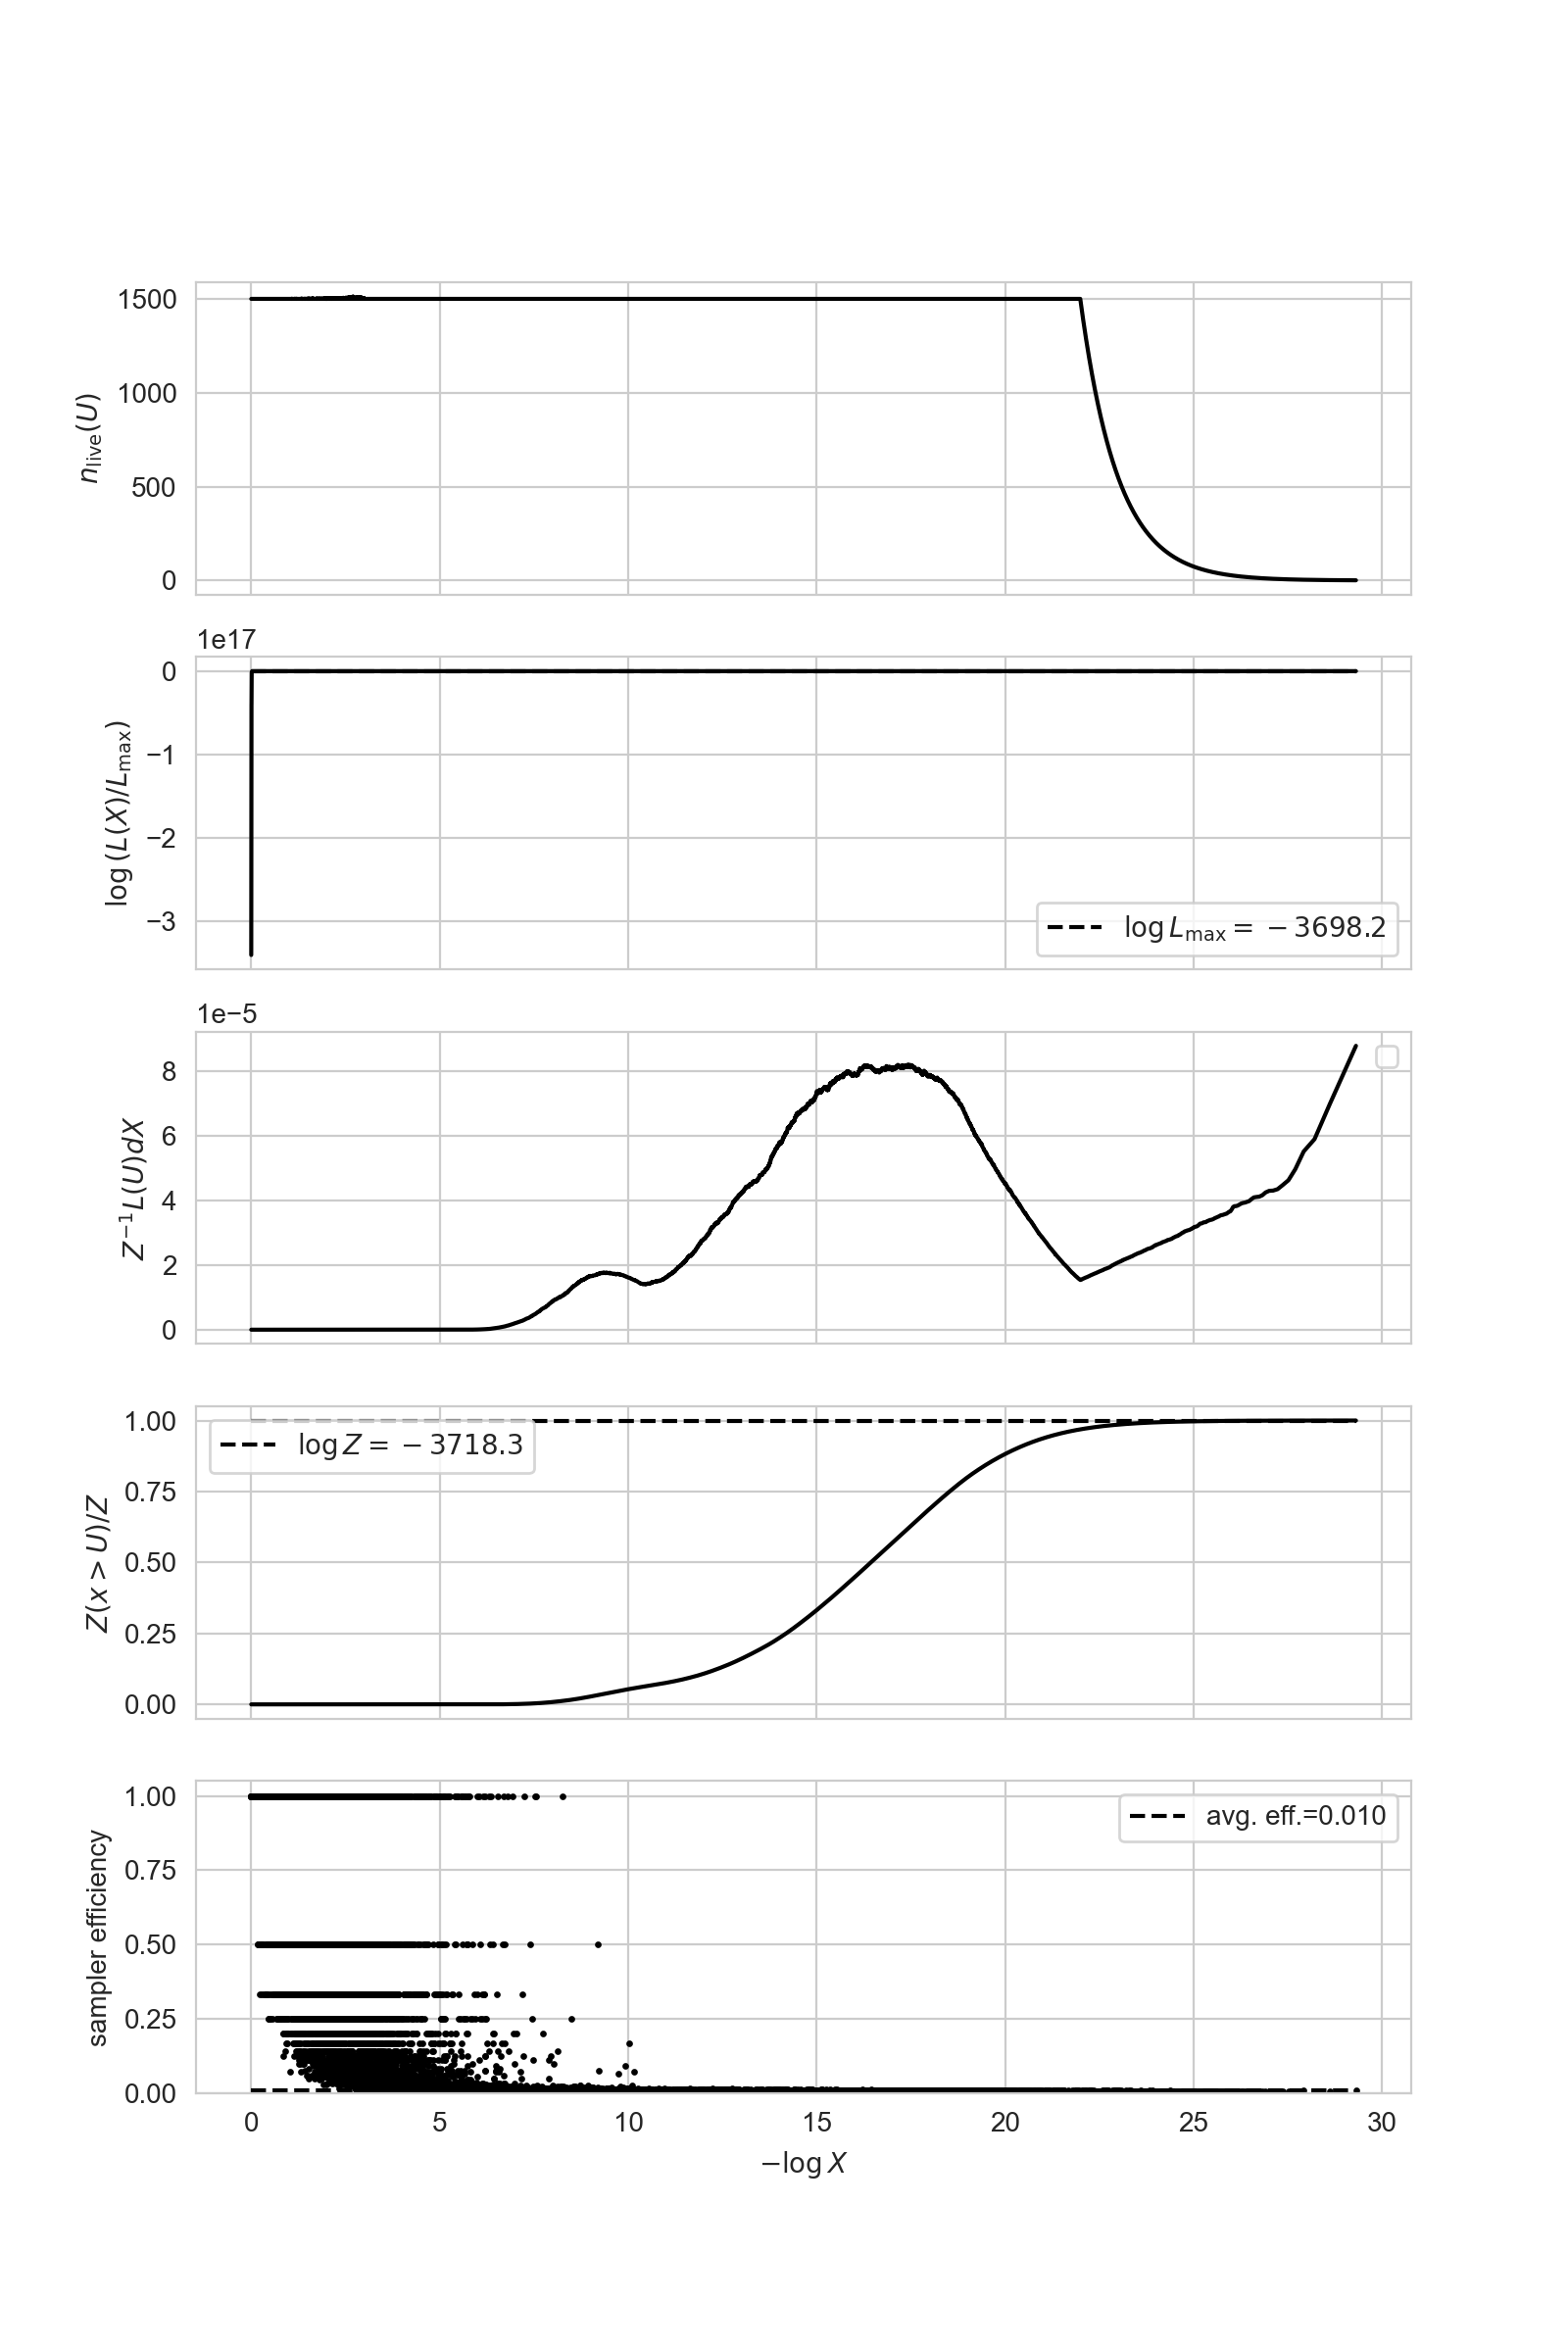

WARNING[2023-10-27 08:50:40,743]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


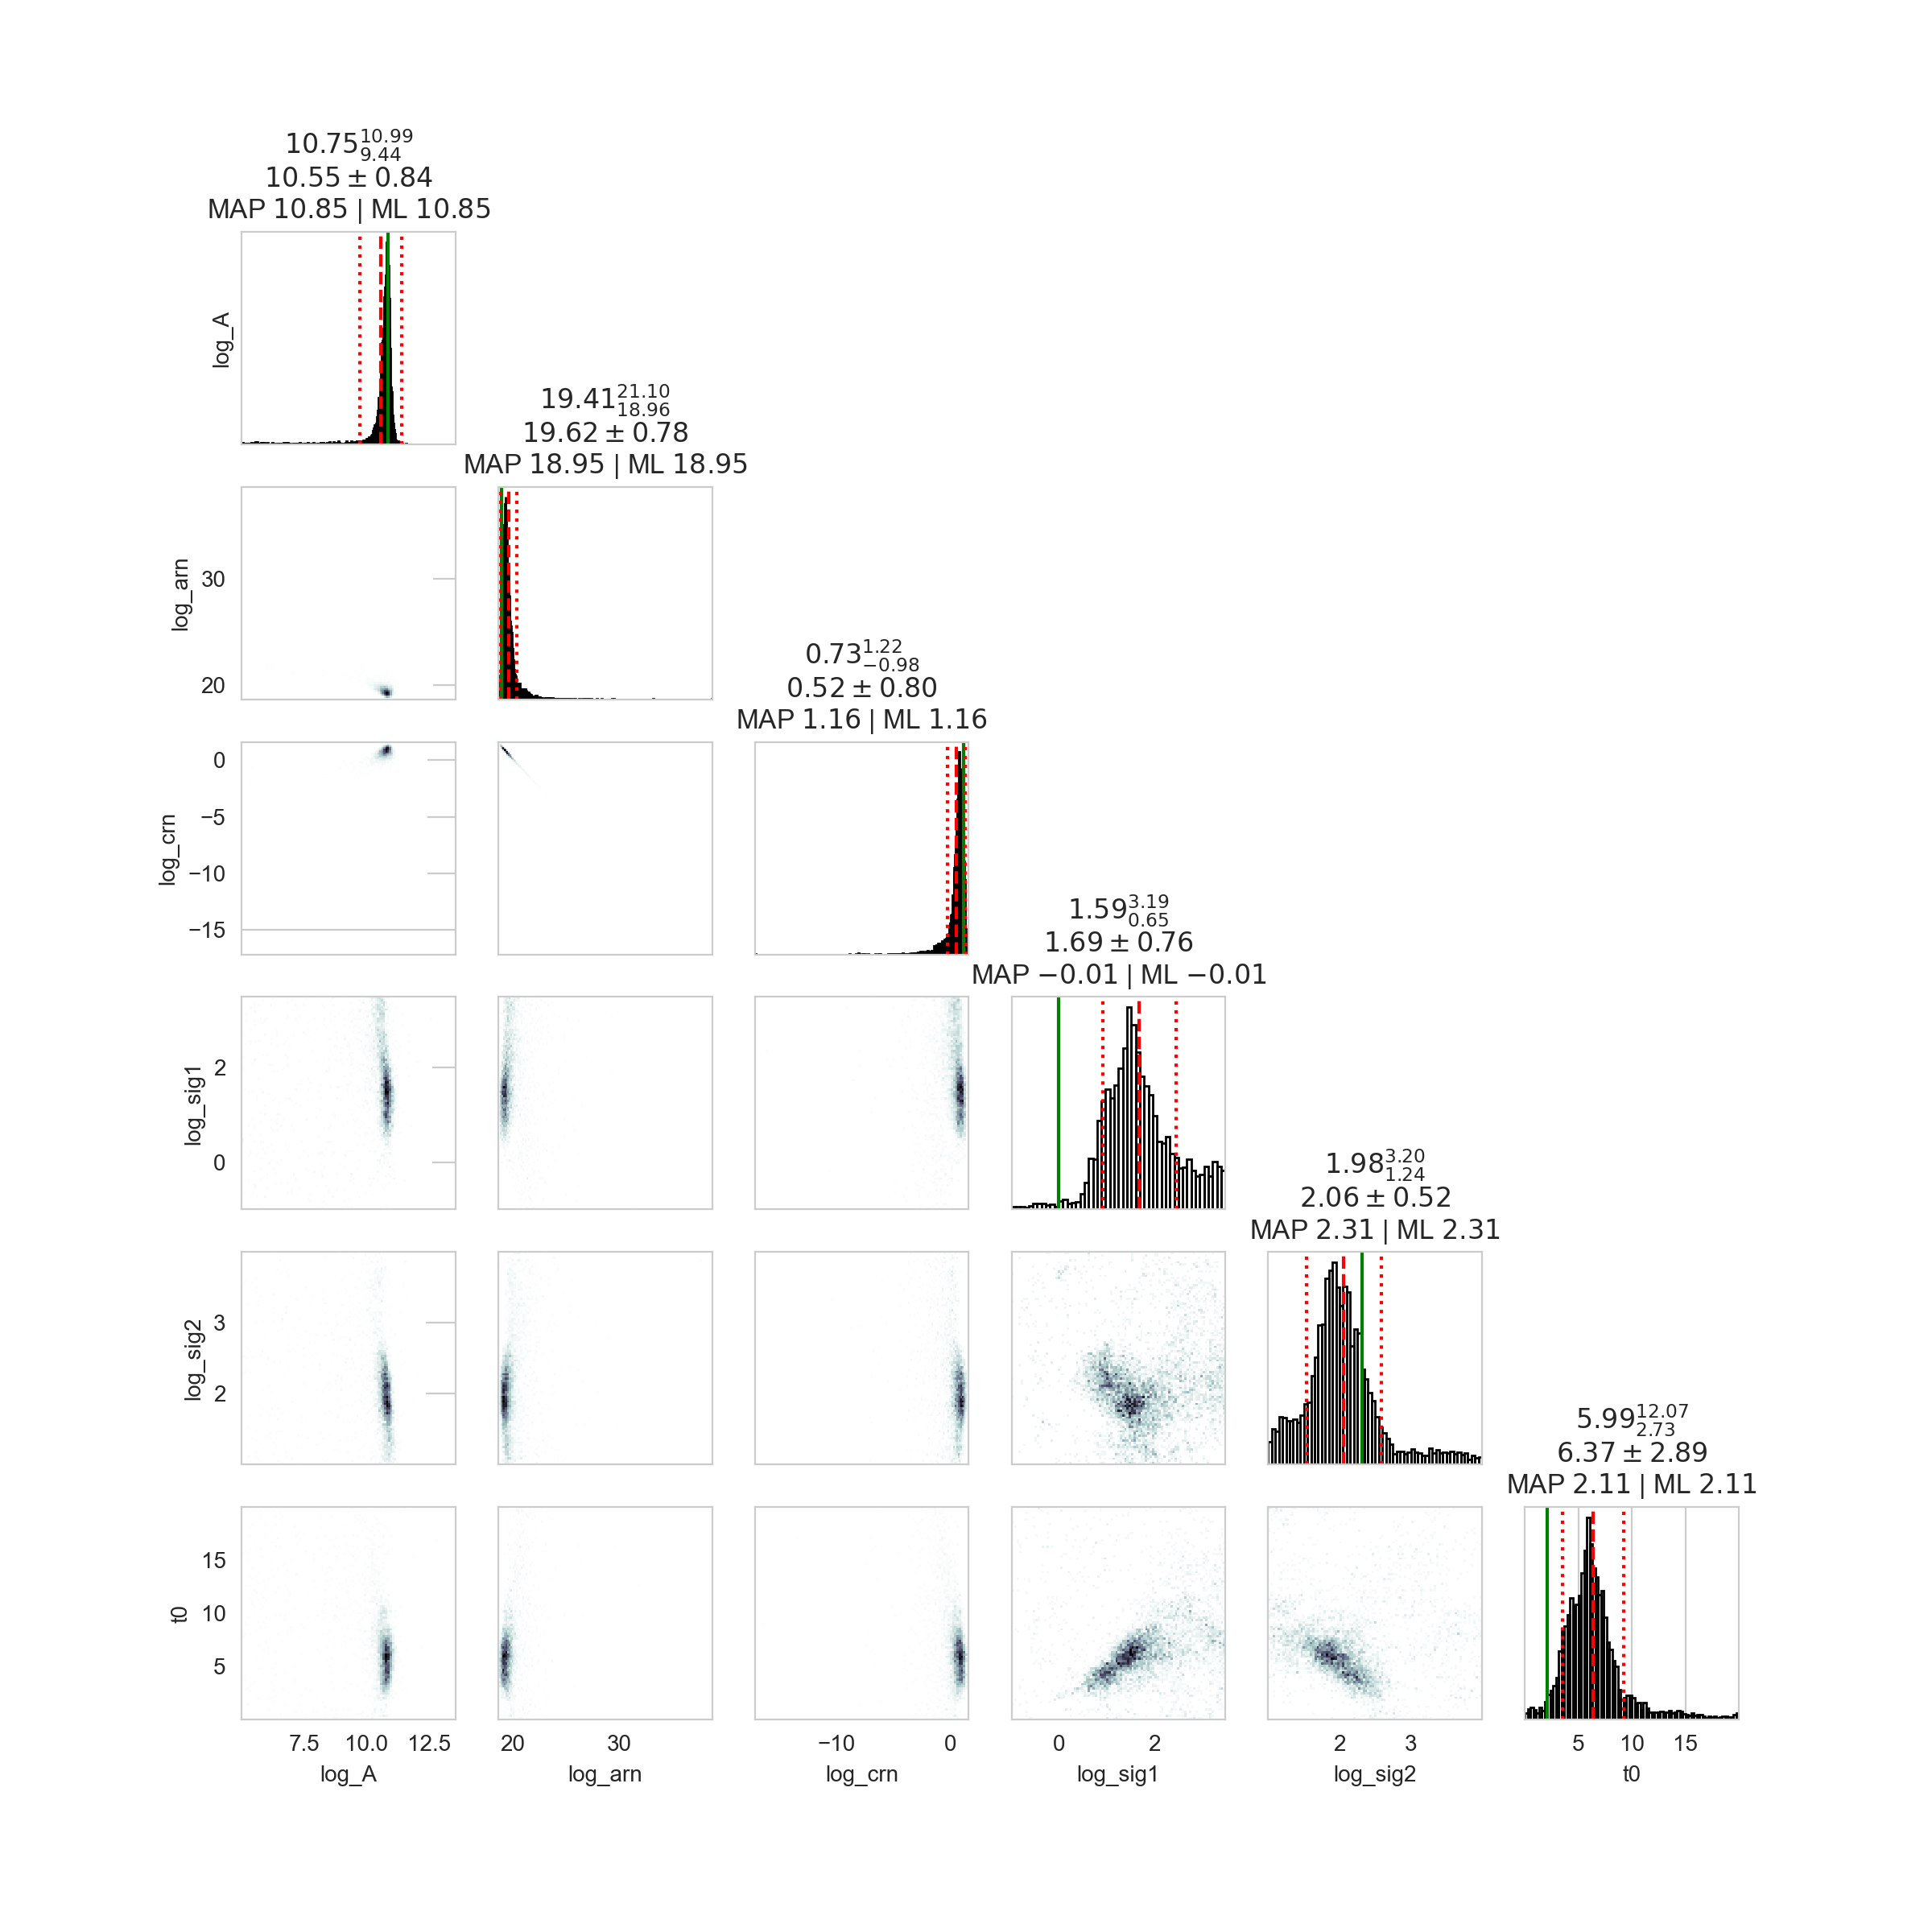

In [16]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


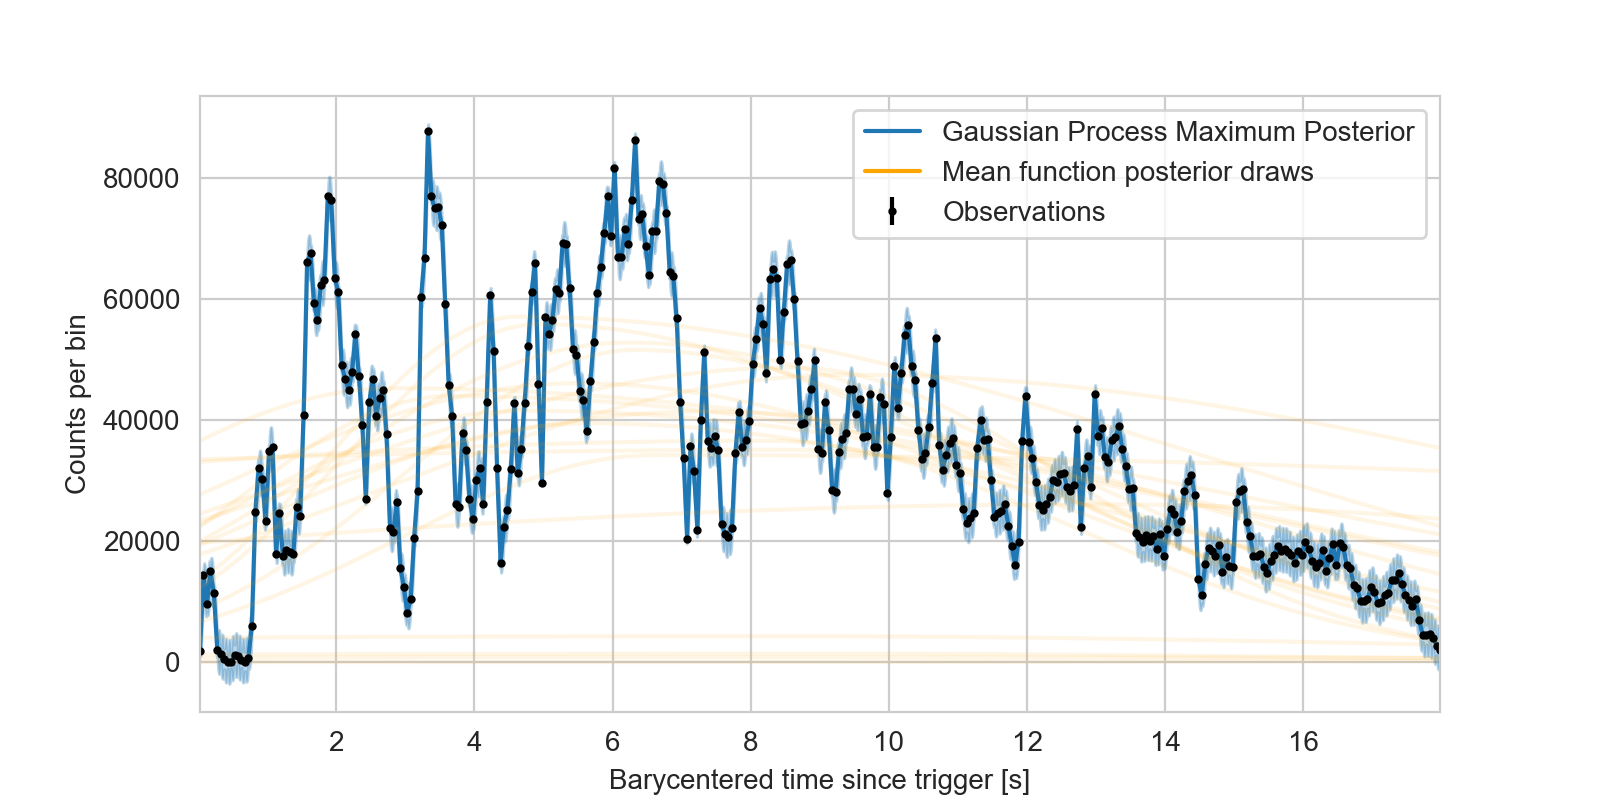

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc1, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc1.time[0], lc1.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [18]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [19]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc1.time, counts = lc1.counts)

In [20]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc1)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

INFO[2023-10-27 08:51:02,407]: Sanity check...
INFO[2023-10-27 08:51:02,738]: Sanity check passed


Simulation Complete


In [21]:
print("log Evidence: ", gpresult_qporn.get_evidence())

log Evidence:  -3716.7135350454246


In [22]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

log(Bayes factor): 1.5383378016008464


In [23]:
gpresult_qporn.get_evidence()

Array(-3716.71353505, dtype=float64)

In [24]:
with open(datadir+"intregal_drw_qpo_lc1_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [25]:
gpresult_qporn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 5460894
# samples: 42000
# slices: 972000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 130.0
# likelihood evals / slice: 5.6
--------
logZ=-3716.71 +- 0.11
H=3700.0
ESS=7116
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.78 +- 0.53 | 10.7 / 10.85 / 10.95 | 10.9 | 10.9
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 18.1 +- 3.1 | 15.2 / 19.1 / 19.5 | 17.8 | 17.8
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 12.3 +- 5.1 | 5.6 / 11.7 / 19.3 | 18.8 | 18.8
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -0.1 +- 2.9 | -5.6 / 0.9 / 1.2 | -3.1 | -3.1
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 23.0 +- 16.0 | 1.0 / 31.0 / 38.0 | 1.0 | 1.0
--------
lo

<IPython.core.display.Javascript object>


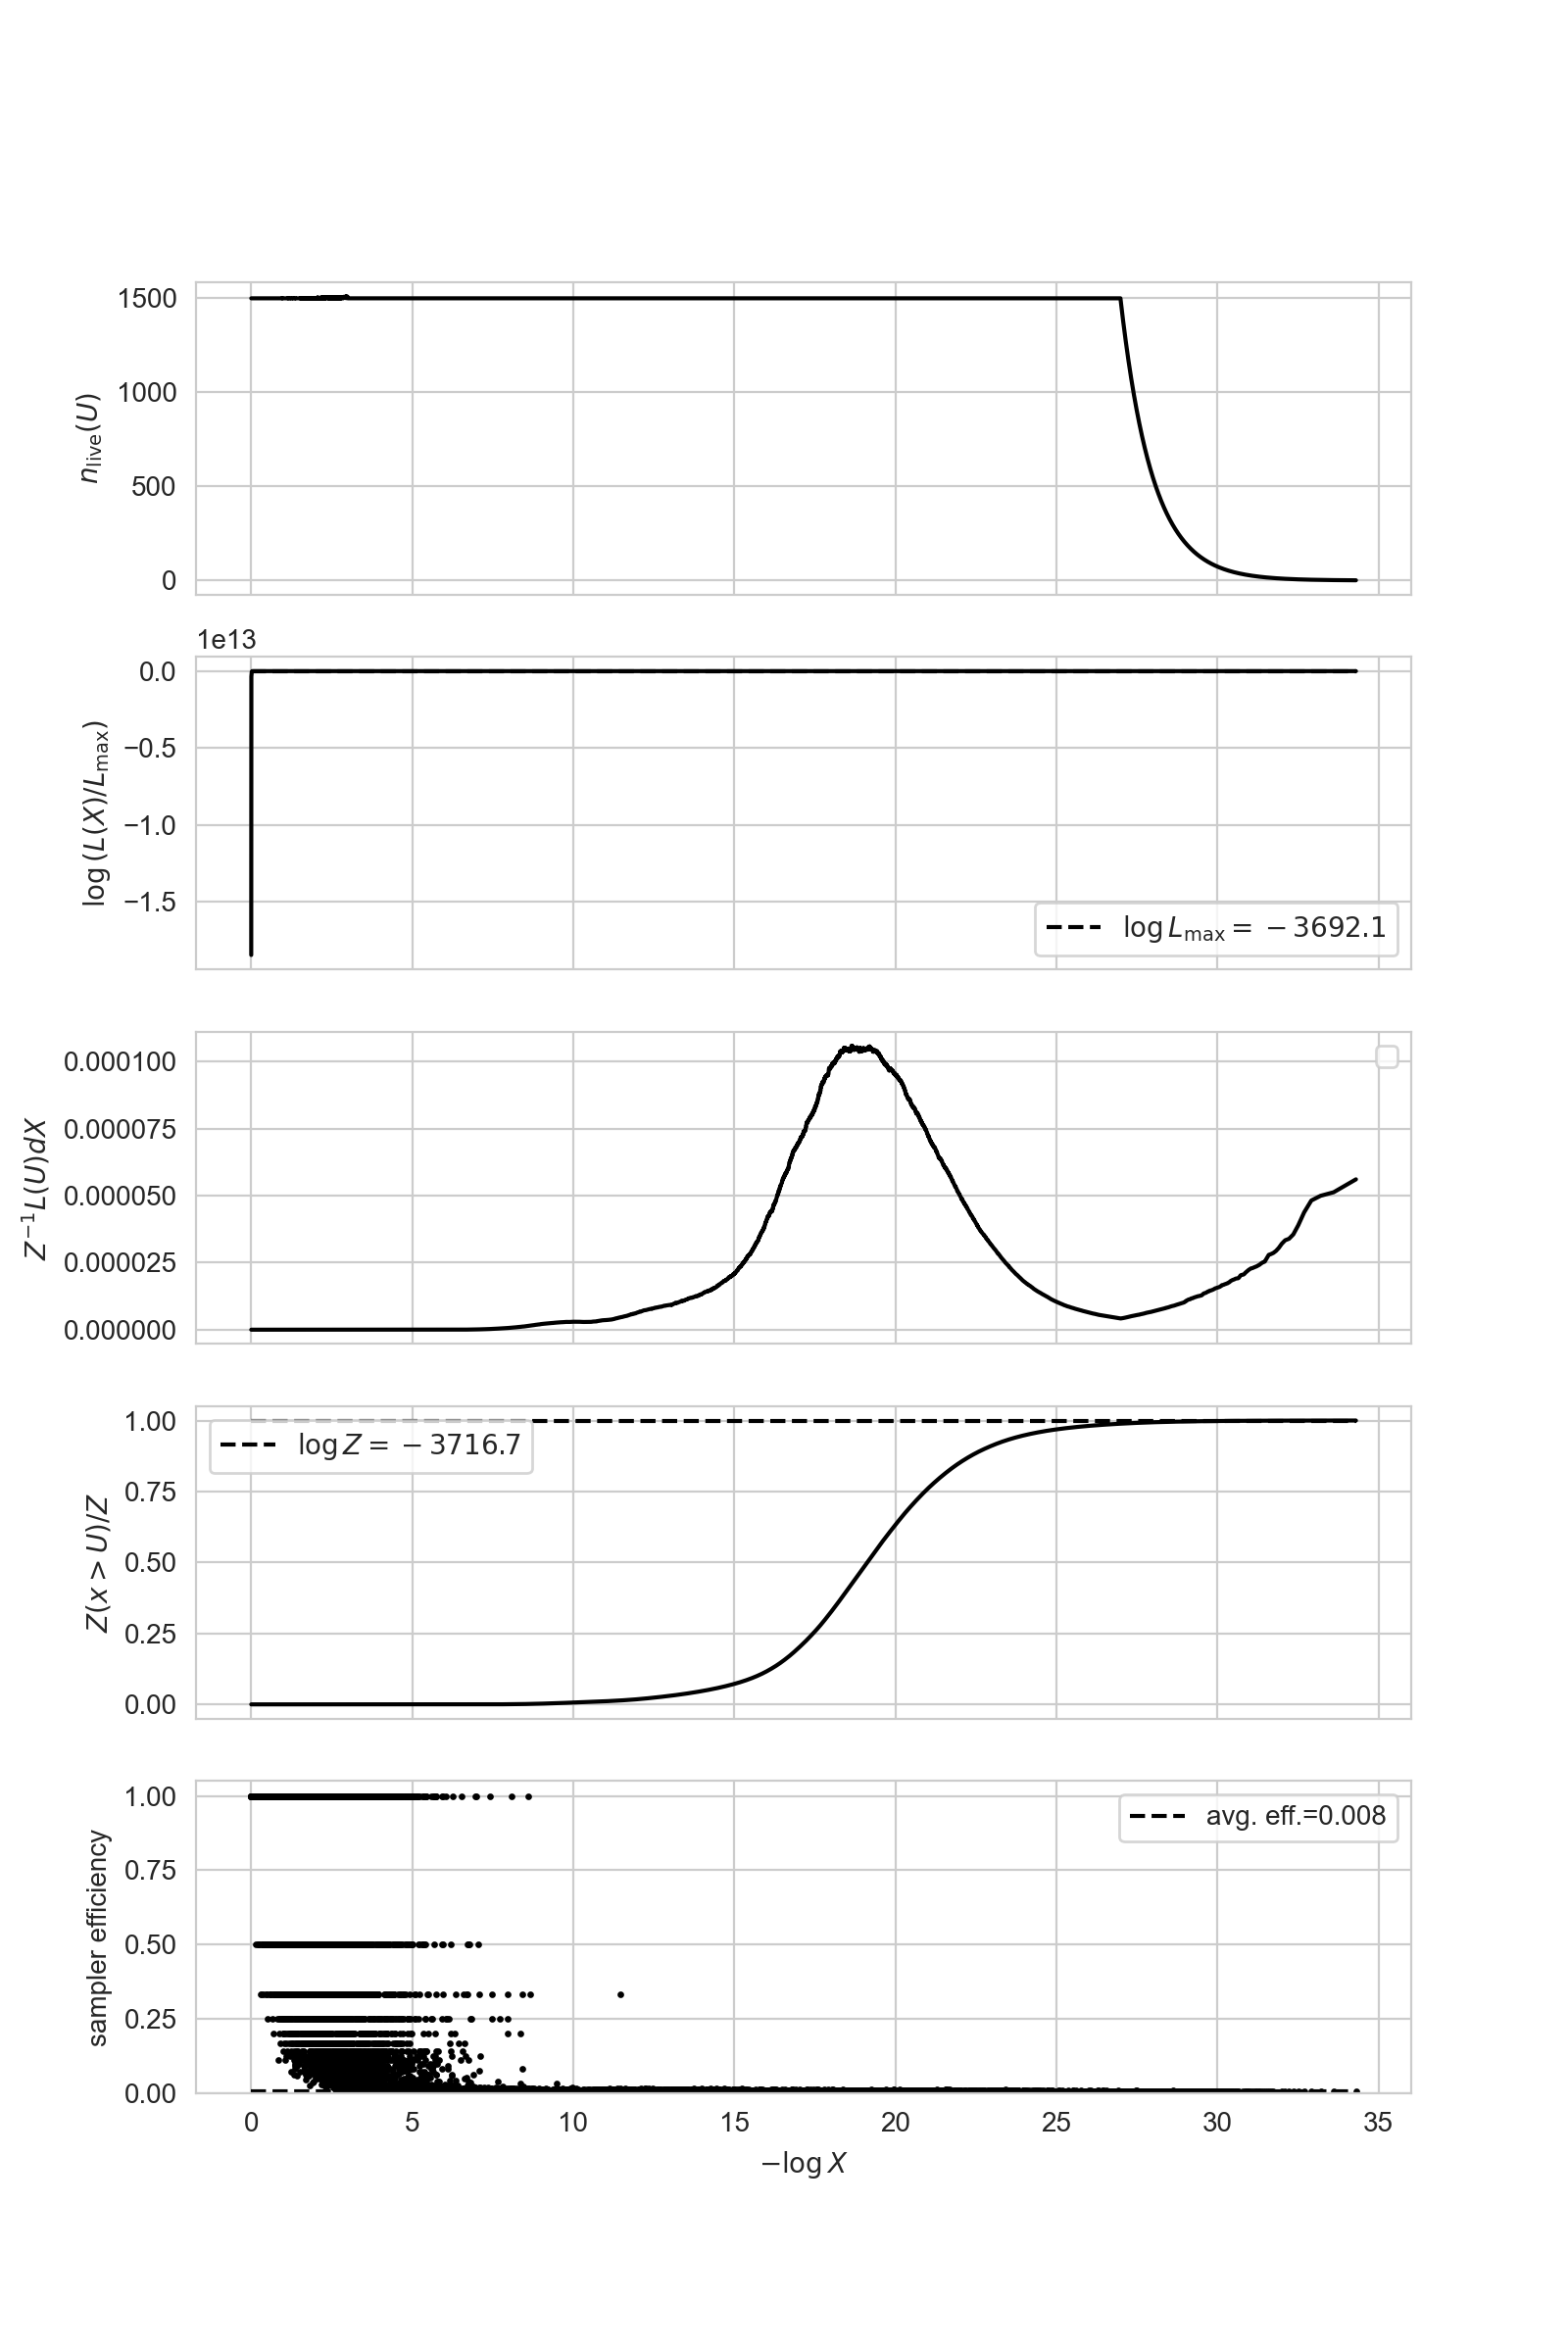

WARNING[2023-10-27 09:05:42,727]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [26]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


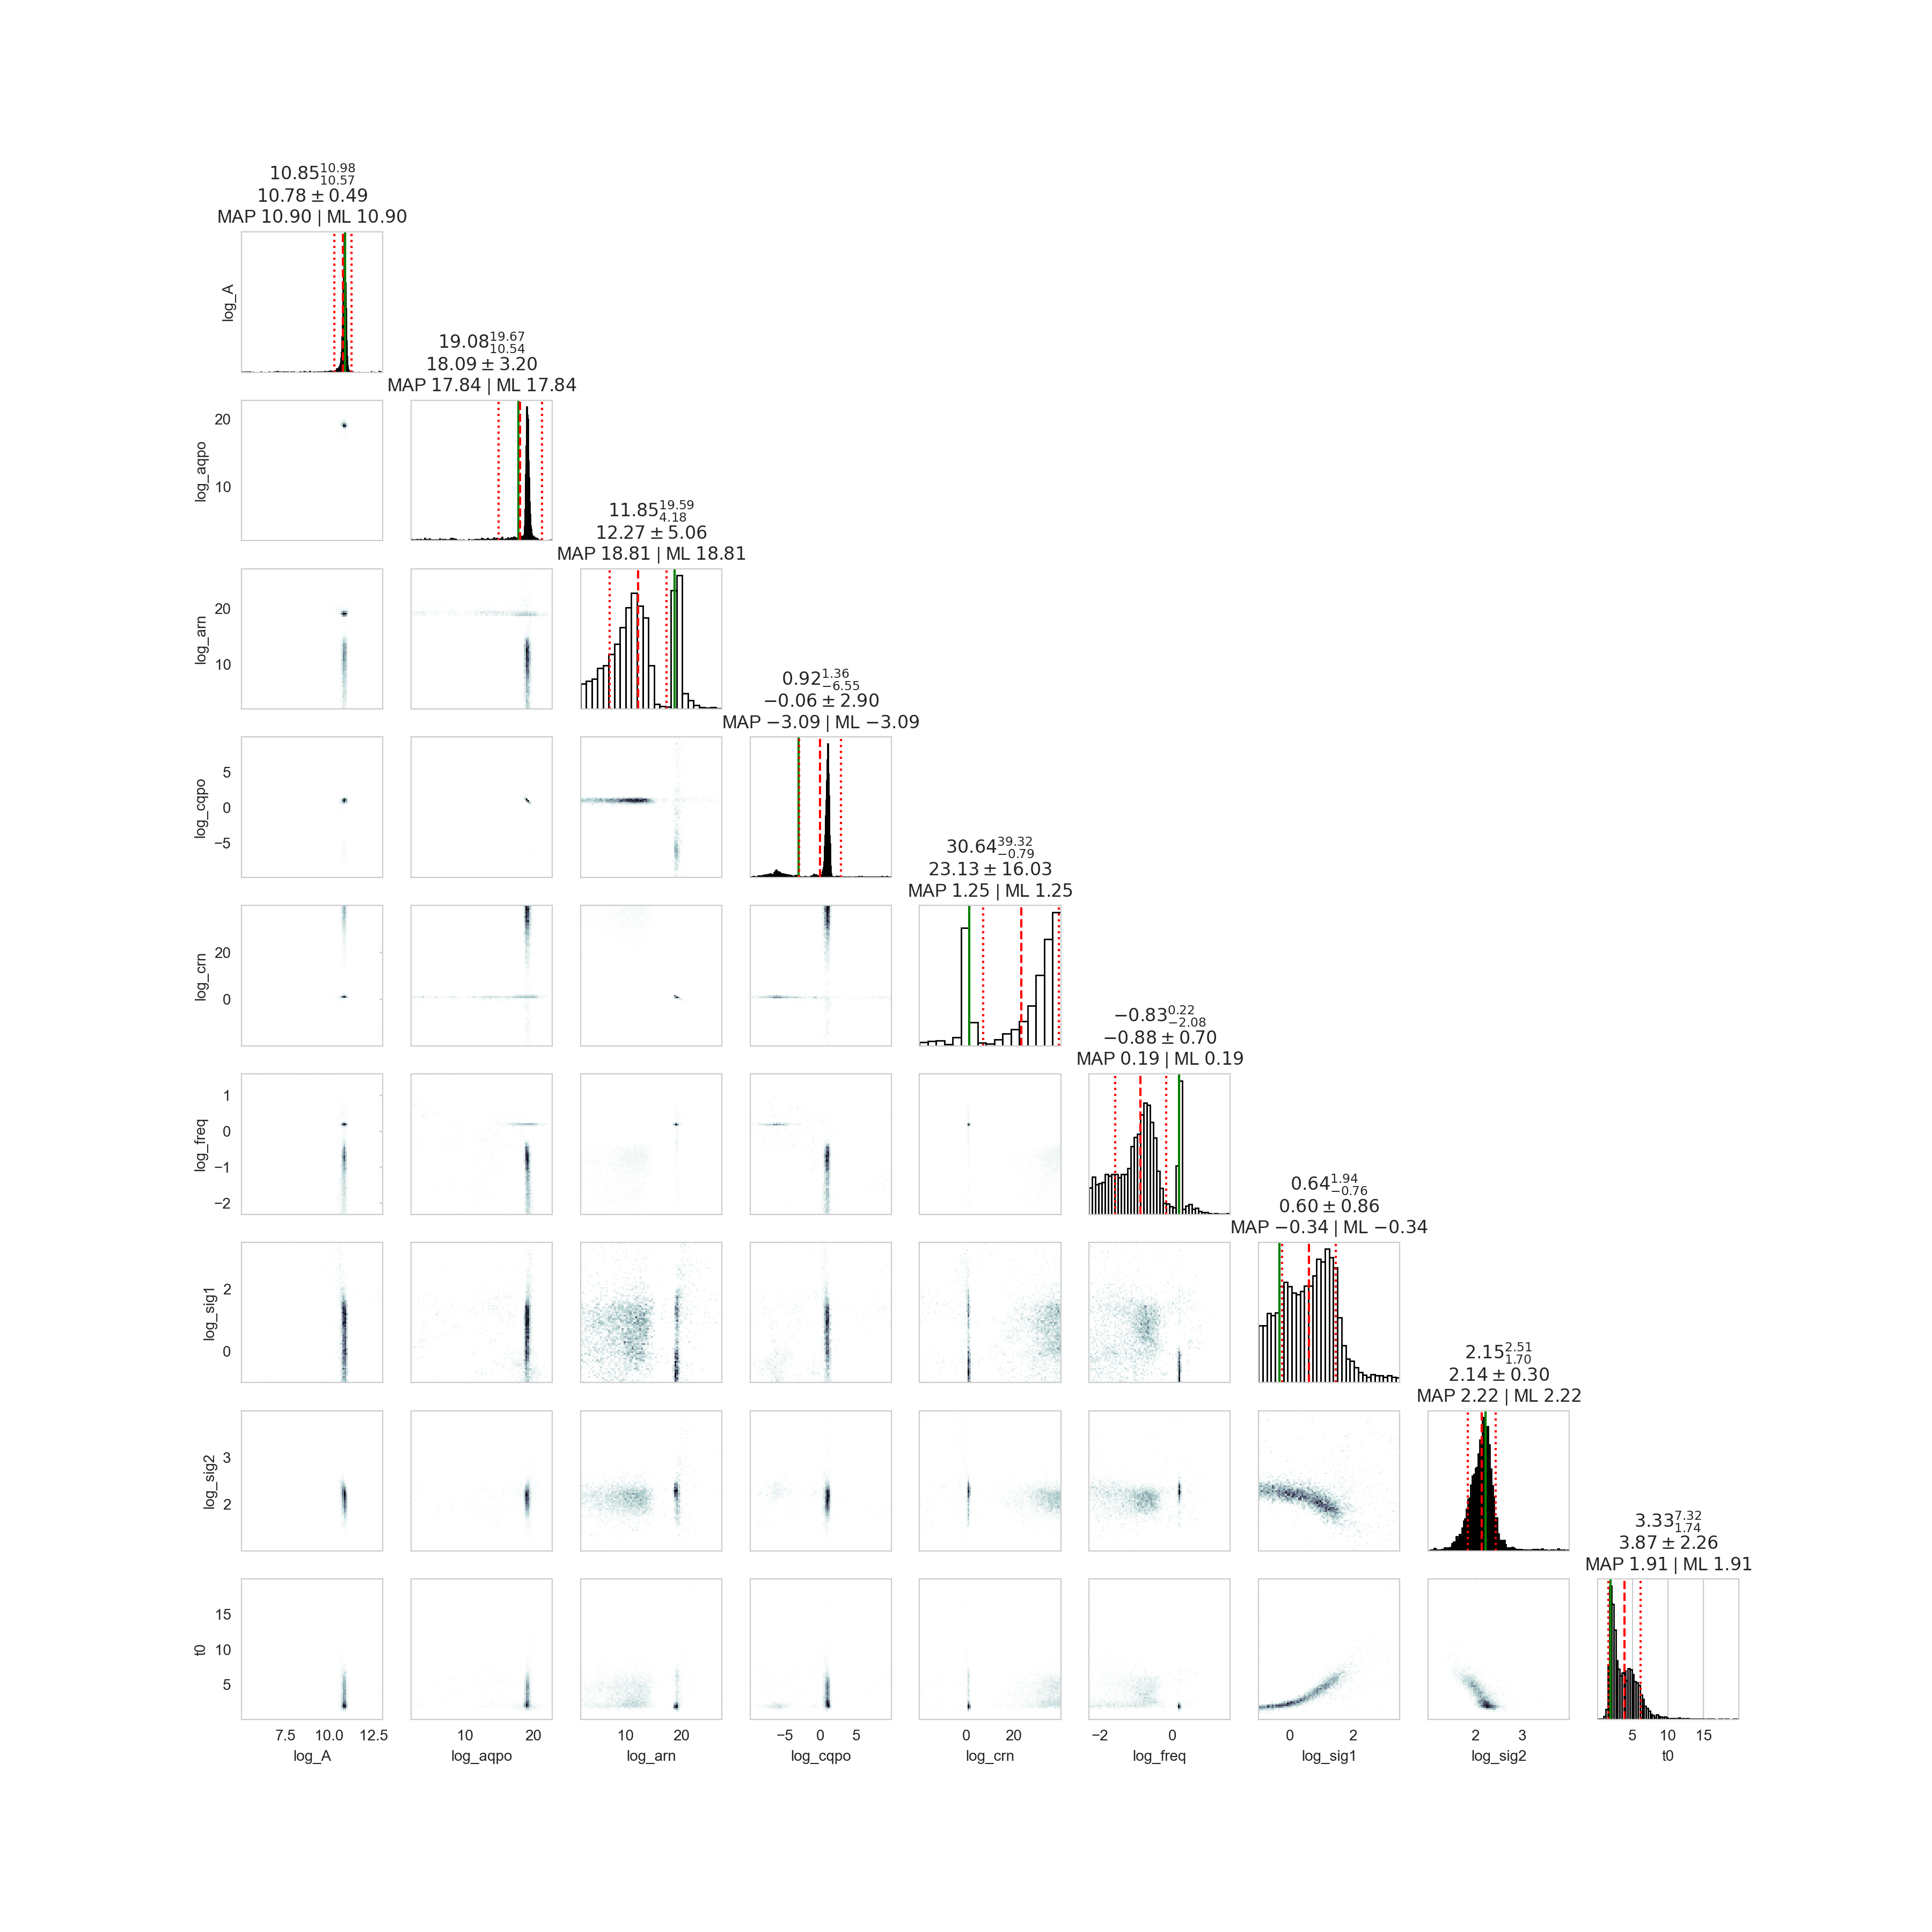

In [29]:
gpresult_qporn.plot_cornerplot()

<IPython.core.display.Javascript object>


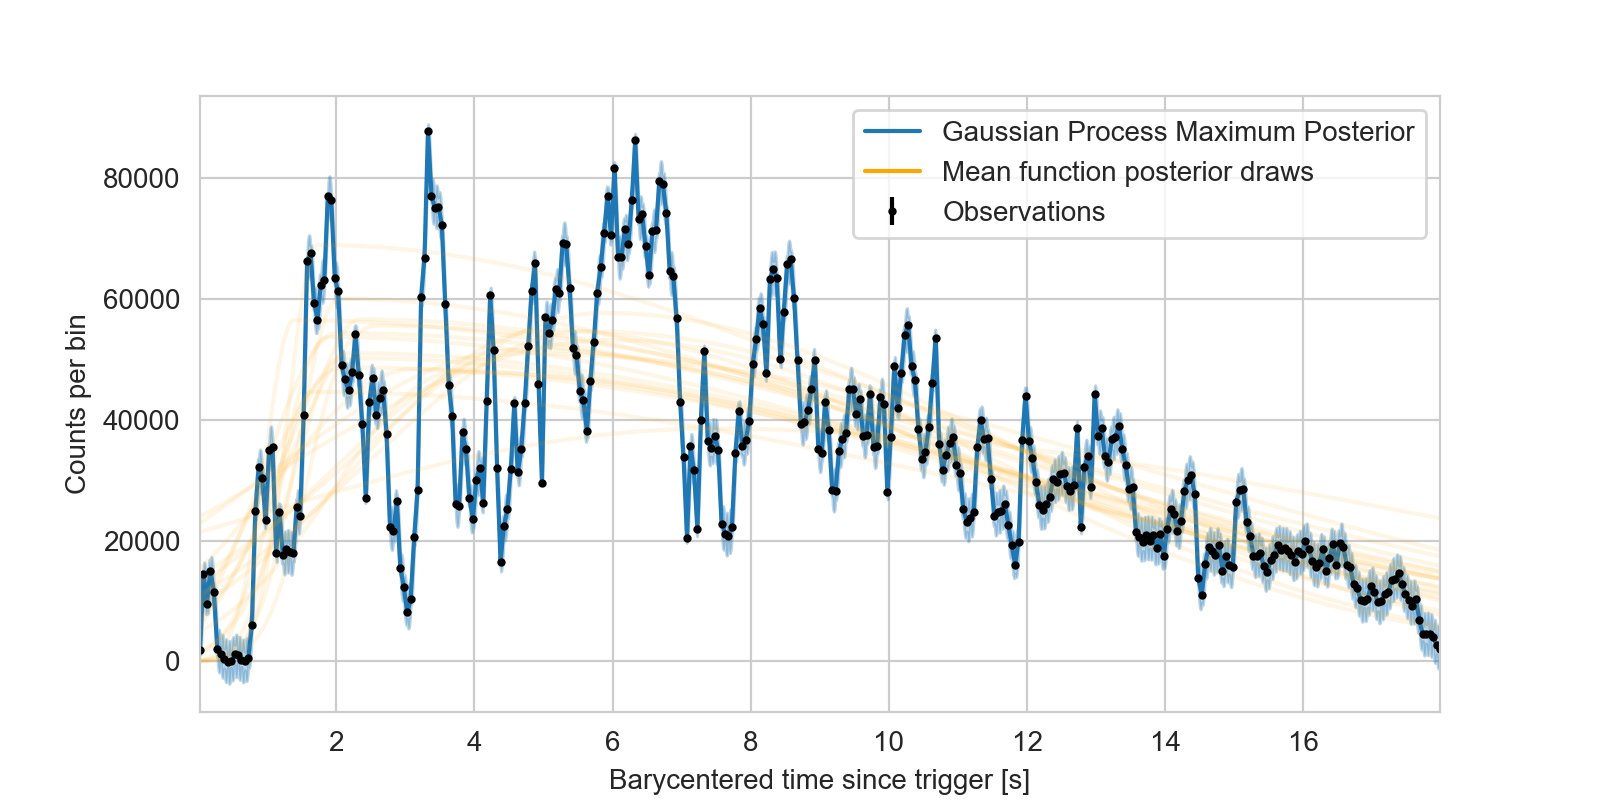

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc1, gpresult_qporn.results, "QPO_plus_RN", mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc1.time[0], lc1.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [31]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1334)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [32]:
freq = np.exp(freq_resampled)
period = 1.0/freq

<IPython.core.display.Javascript object>


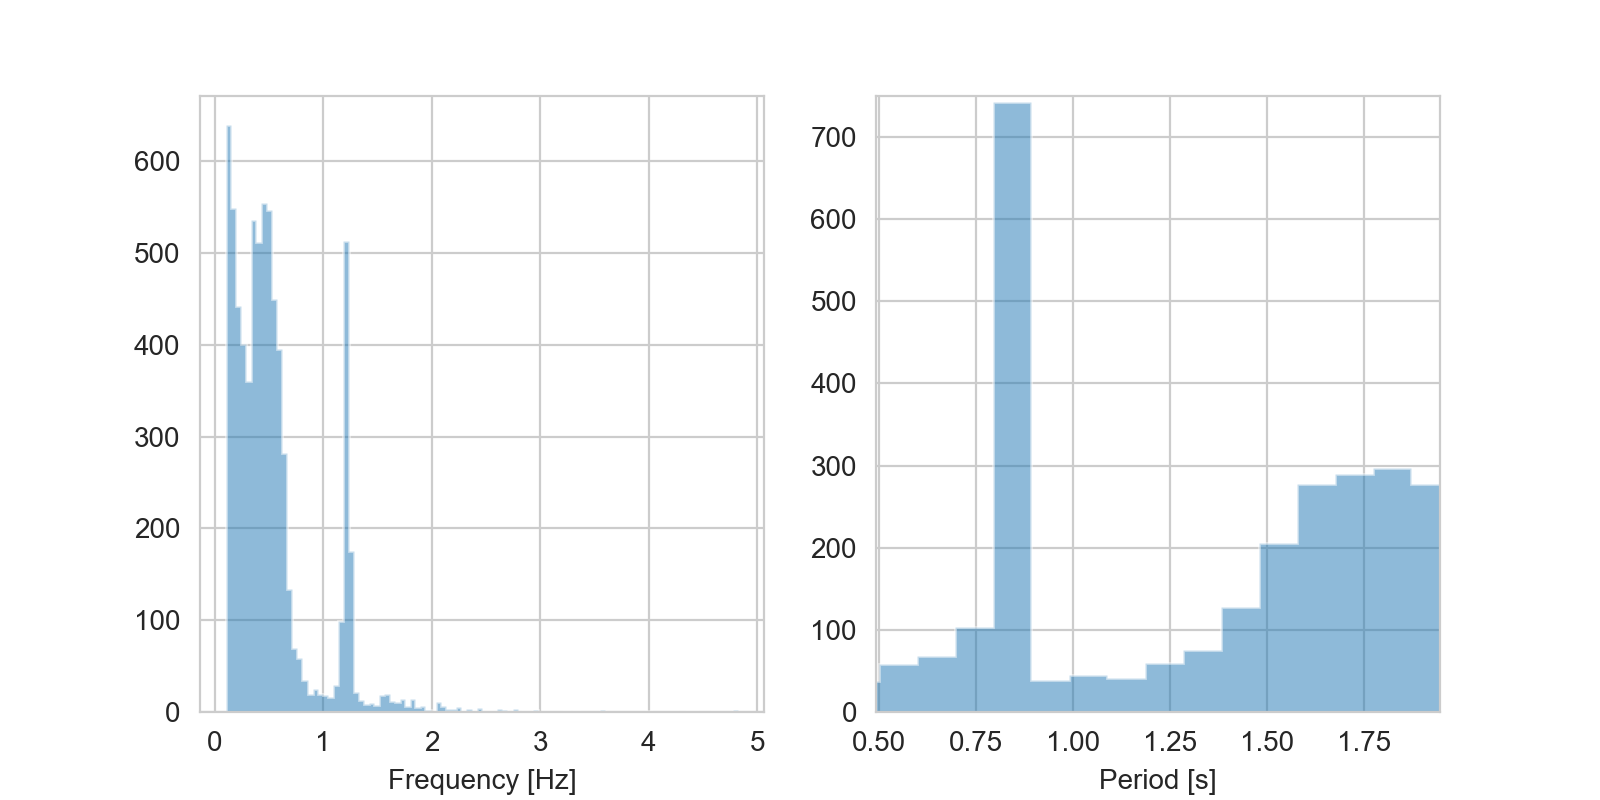

Text(0.5, 0, 'Period [s]')

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [34]:
np.log10(np.exp(gpresult_qporn.get_evidence() - res_rn.log_Z_mean))

0.668091618538427

## Second Light Curve

Let's look at the second segment:

In [48]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [49]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 25.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc2.time, counts = lc2.counts)

In [50]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc2)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

INFO[2023-10-27 09:44:51,491]: Sanity check...
INFO[2023-10-27 09:44:51,501]: Sanity check passed


Simulation Complete


In [51]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -6524.942789174645


In [52]:
### SAVE POSTERIOR SAMPLES
with open(datadir+"intregal_drw_lc2_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)

In [40]:
### LOAD POSTERIOR SAMPLES

with open(datadir+"intregal_drw_lc2_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [53]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 4140403
# samples: 40500
# slices: 594000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 102.2
# likelihood evals / slice: 6.8
--------
logZ=-6524.94 +- 0.12
H=6500.0
ESS=4906
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 9.401 +- 0.068 | 9.316 / 9.401 / 9.482 | 9.403 | 9.403
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 14.75 +- 0.17 | 14.55 / 14.73 / 14.98 | 14.68 | 14.68
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.68 +- 0.18 | 0.43 / 0.7 / 0.89 | 0.74 | 0.74
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.83 +- 0.16 | -0.97 / -0.86 / -0.63 | -0.91 | -0.91
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 1.9 +- 0.094 | 1.789 / 1.897 / 2.02

<IPython.core.display.Javascript object>


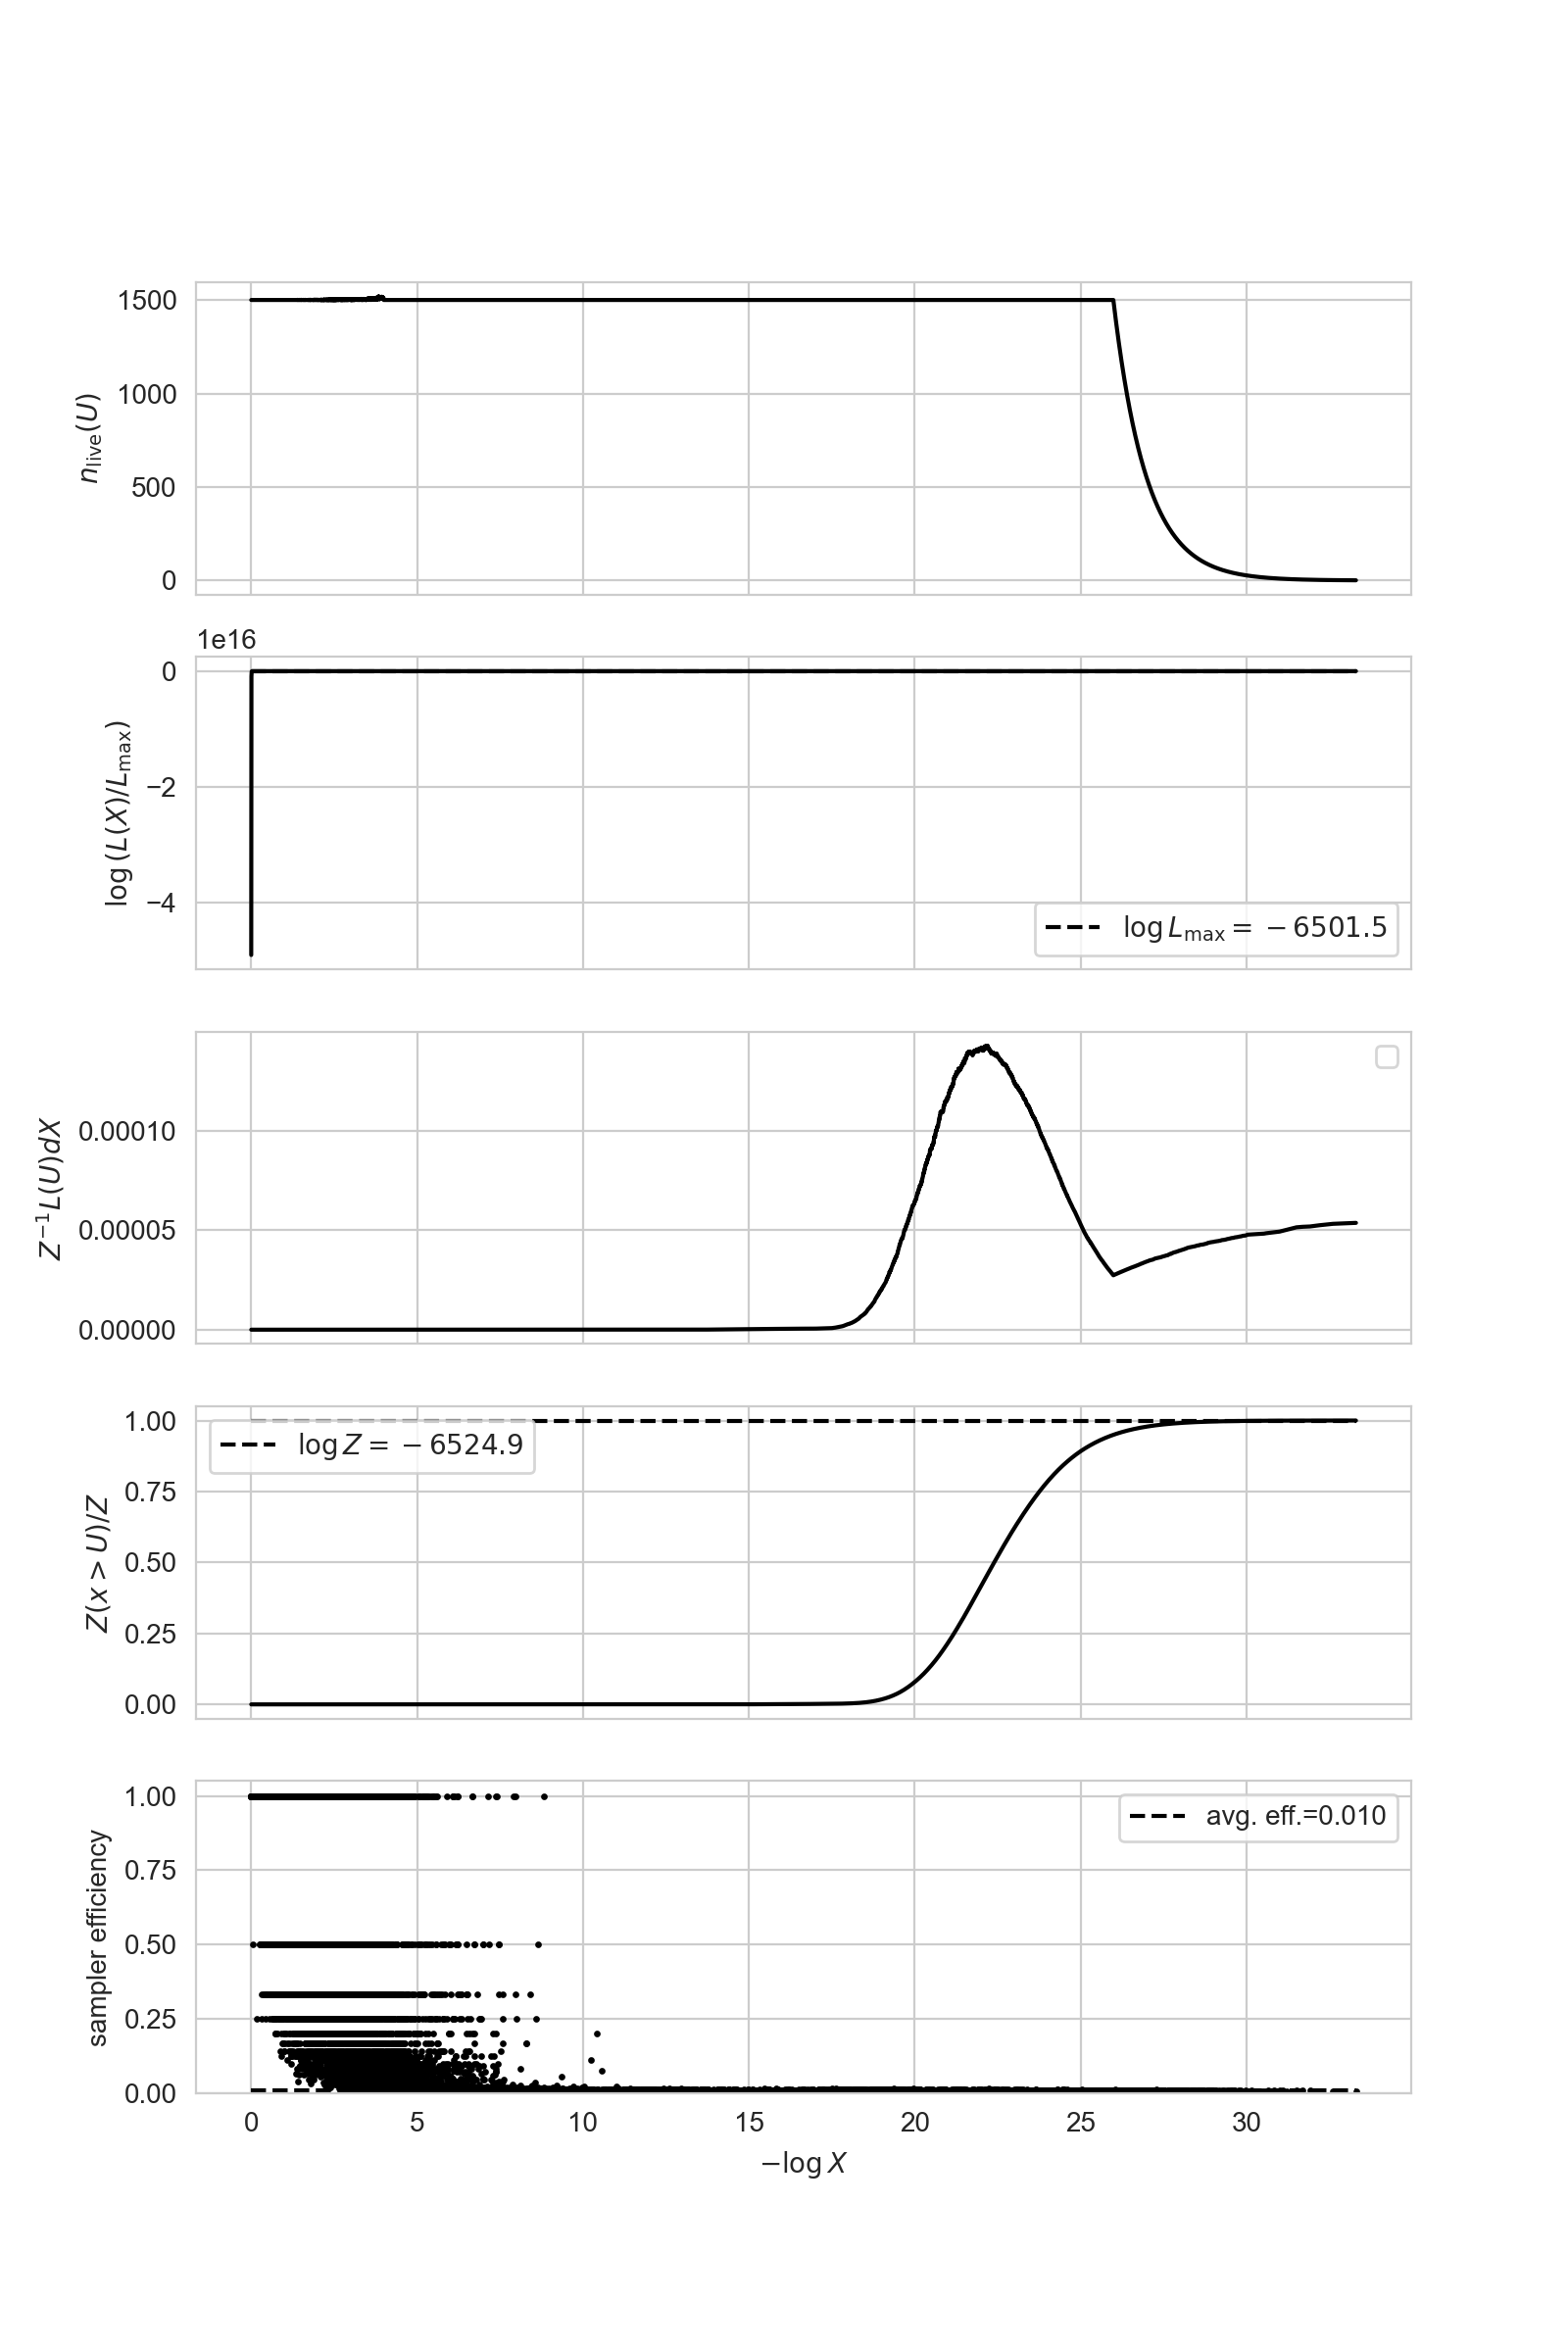

WARNING[2023-10-27 09:52:36,817]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [54]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


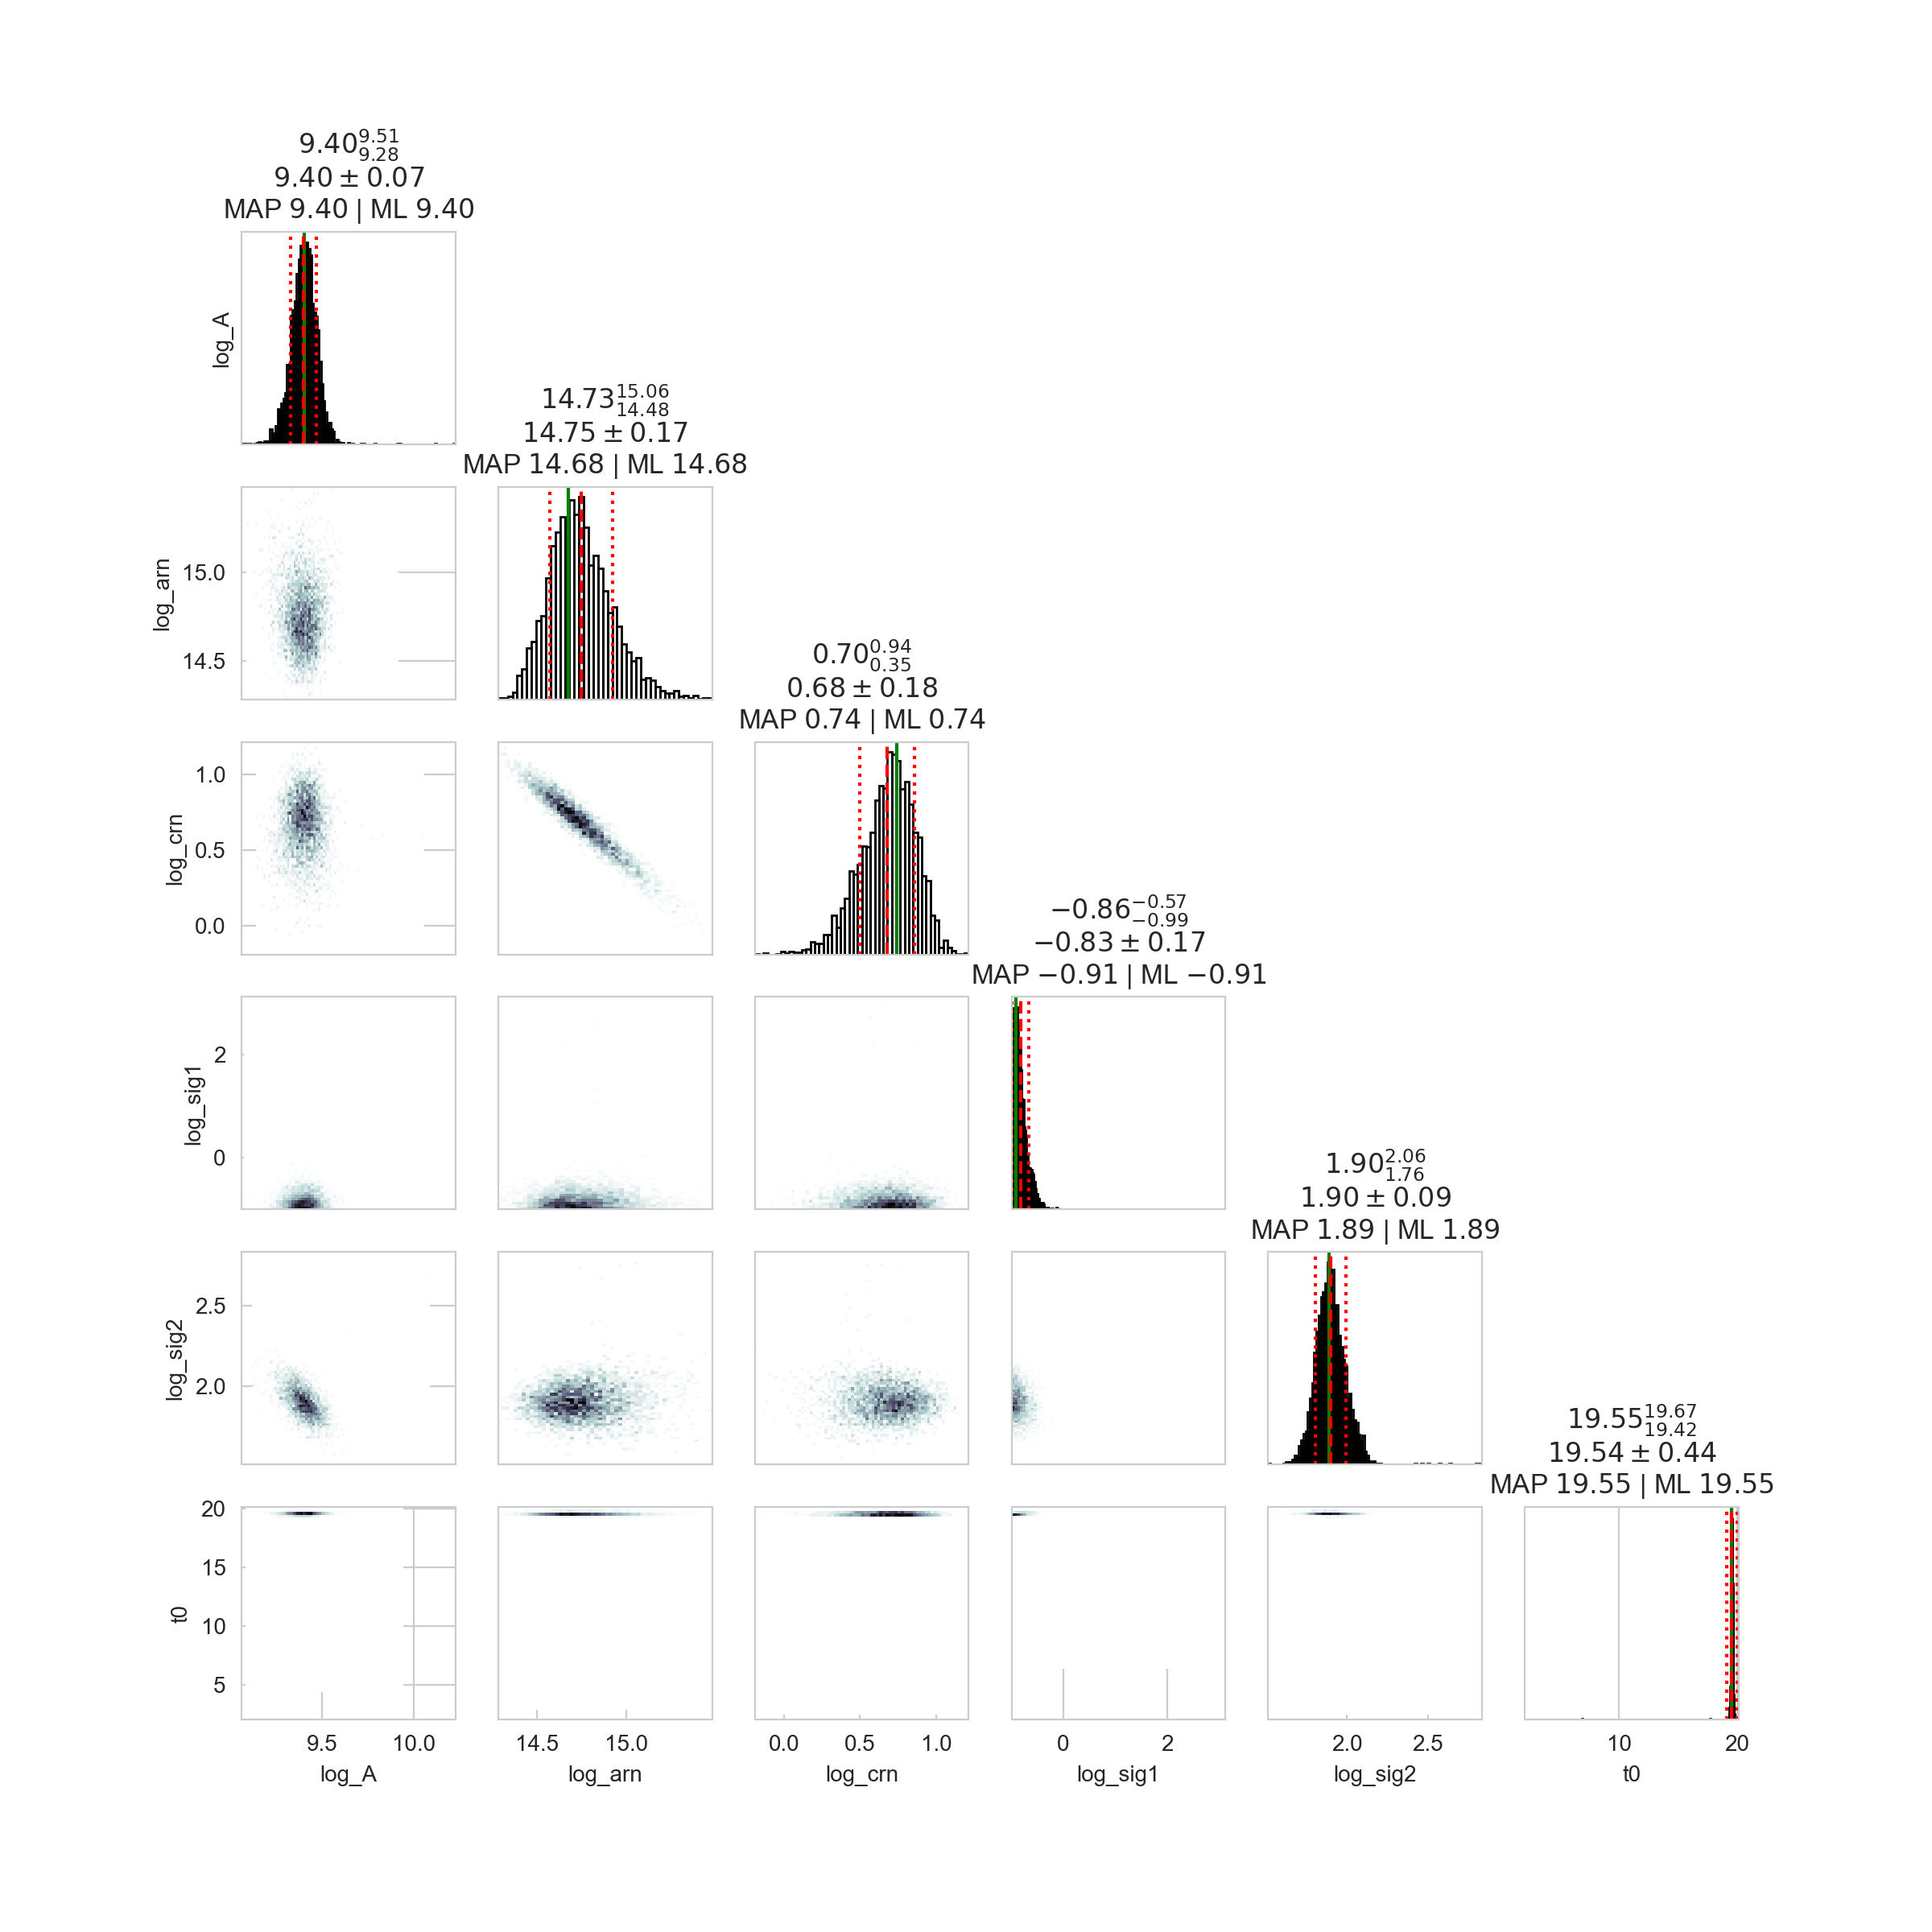

In [55]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


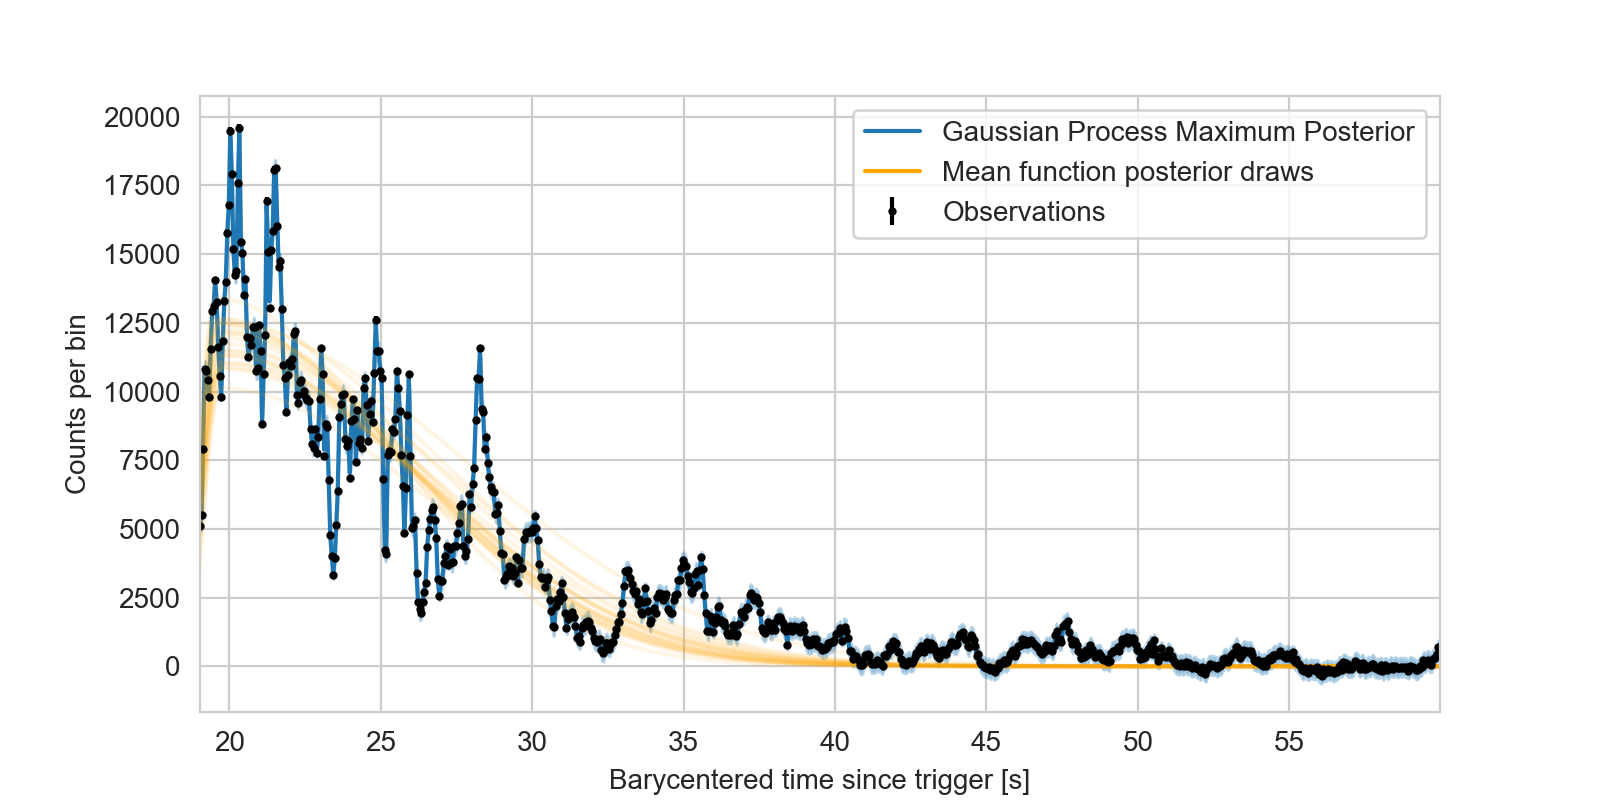

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc2, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc2.time[0], lc2.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [57]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [85]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 21.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-3, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc2.time, counts = lc2.counts)

In [86]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc2)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=4500)

INFO[2023-10-27 12:13:03,471]: Sanity check...
INFO[2023-10-27 12:13:03,488]: Sanity check passed
2023-10-27 12:13:09.643216: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.21 = s64[31250]{0} reduce-window(s64[1000000]{0} %broadcast.11, s64[] %constant.69), window={size=32 stride=32}, to_apply=%region_45.2843

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-27 12:13:09.744834: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.103191s
Constant folding an instruction is taking > 1s:

  %reduce-window.21 = s64[31250]{0} reduce-window(s6

Simulation Complete


In [87]:
print("log Evidence: ", gpresult_qporn.get_evidence())

log Evidence:  -6518.033766873272


In [88]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

log(Bayes factor): 10.662329774426325


In [89]:
with open(datadir+"intregal_drw_qpo_lc2_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [90]:
gpresult_qporn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 25262446
# samples: 171000
# slices: 4131000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 147.7
# likelihood evals / slice: 6.1
--------
logZ=-6518.034 +- 0.081
H=6500.0
ESS=21034
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 9.403 +- 0.074 | 9.31 / 9.405 / 9.493 | 9.38 | 9.38
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 10.6 +- 0.52 | 10.03 / 10.57 / 11.22 | 10.62 | 10.62
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 14.76 +- 0.22 | 14.53 / 14.74 / 15.0 | 14.6 | 14.6
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -1.31 +- 0.94 | -2.68 / -1.16 / -0.25 | -0.77 | -0.77
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.54 +- 0.27 | 0.29 / 0.56 / 

<IPython.core.display.Javascript object>


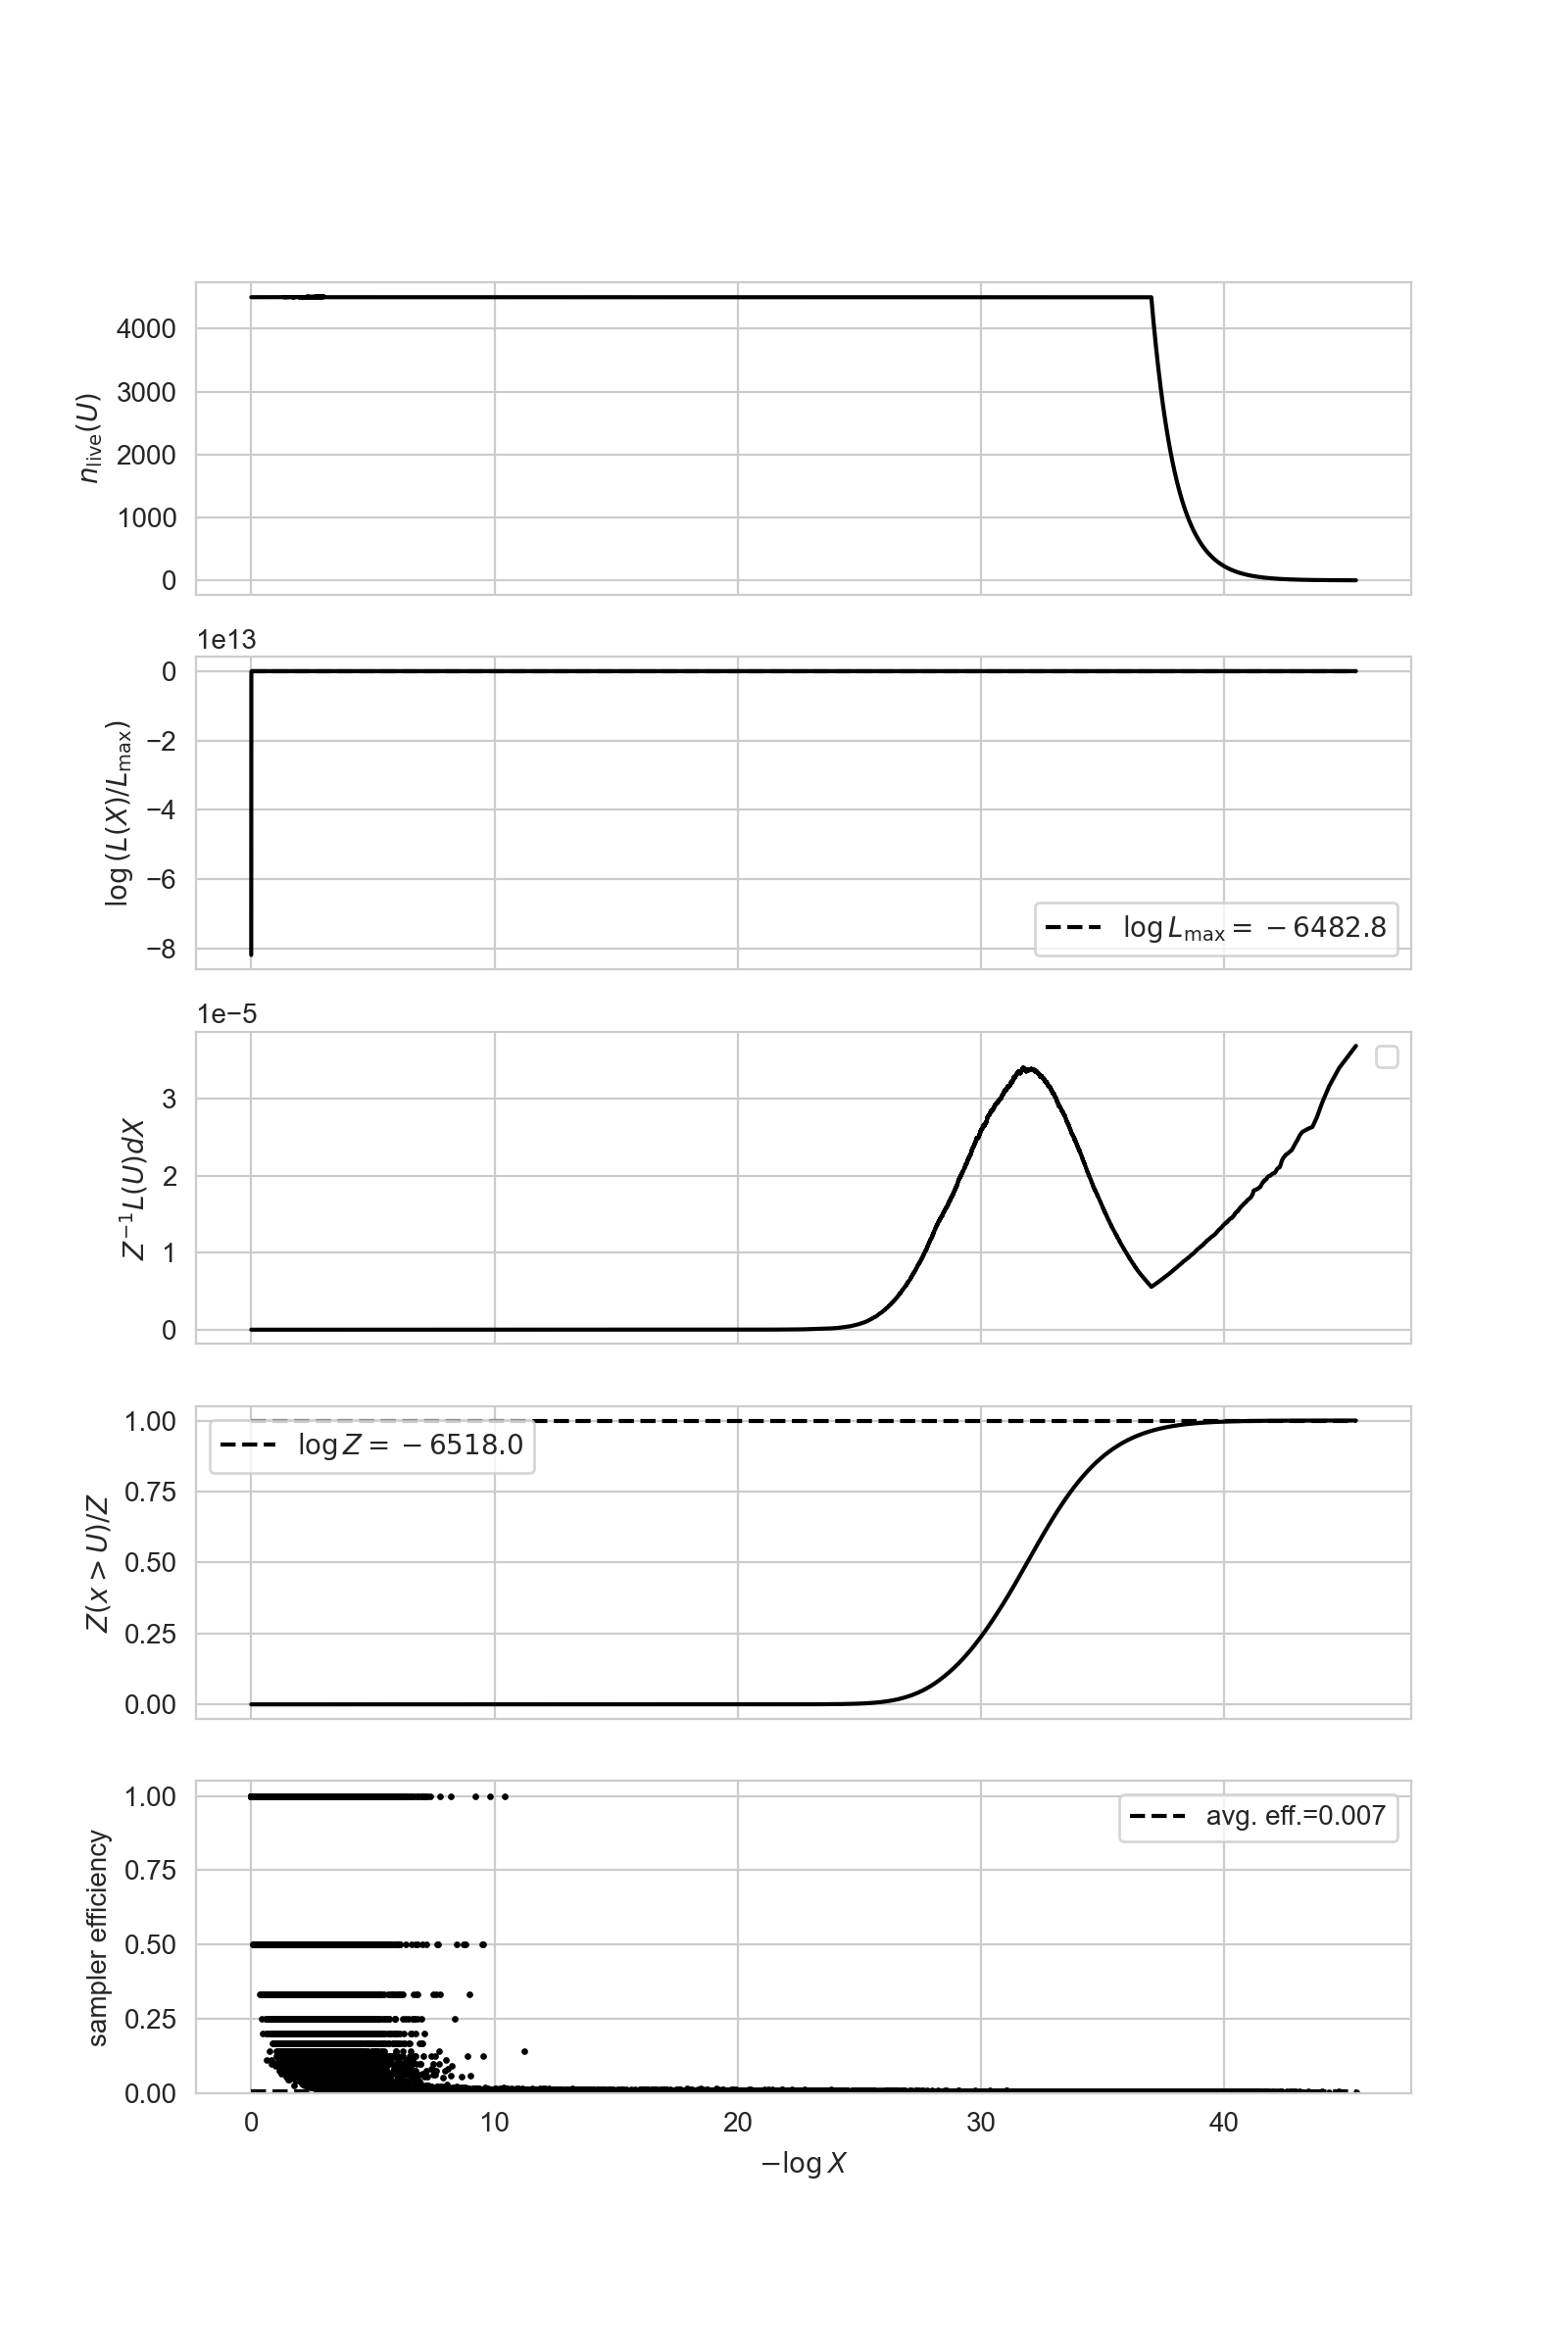

WARNING[2023-10-27 13:50:26,645]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [91]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


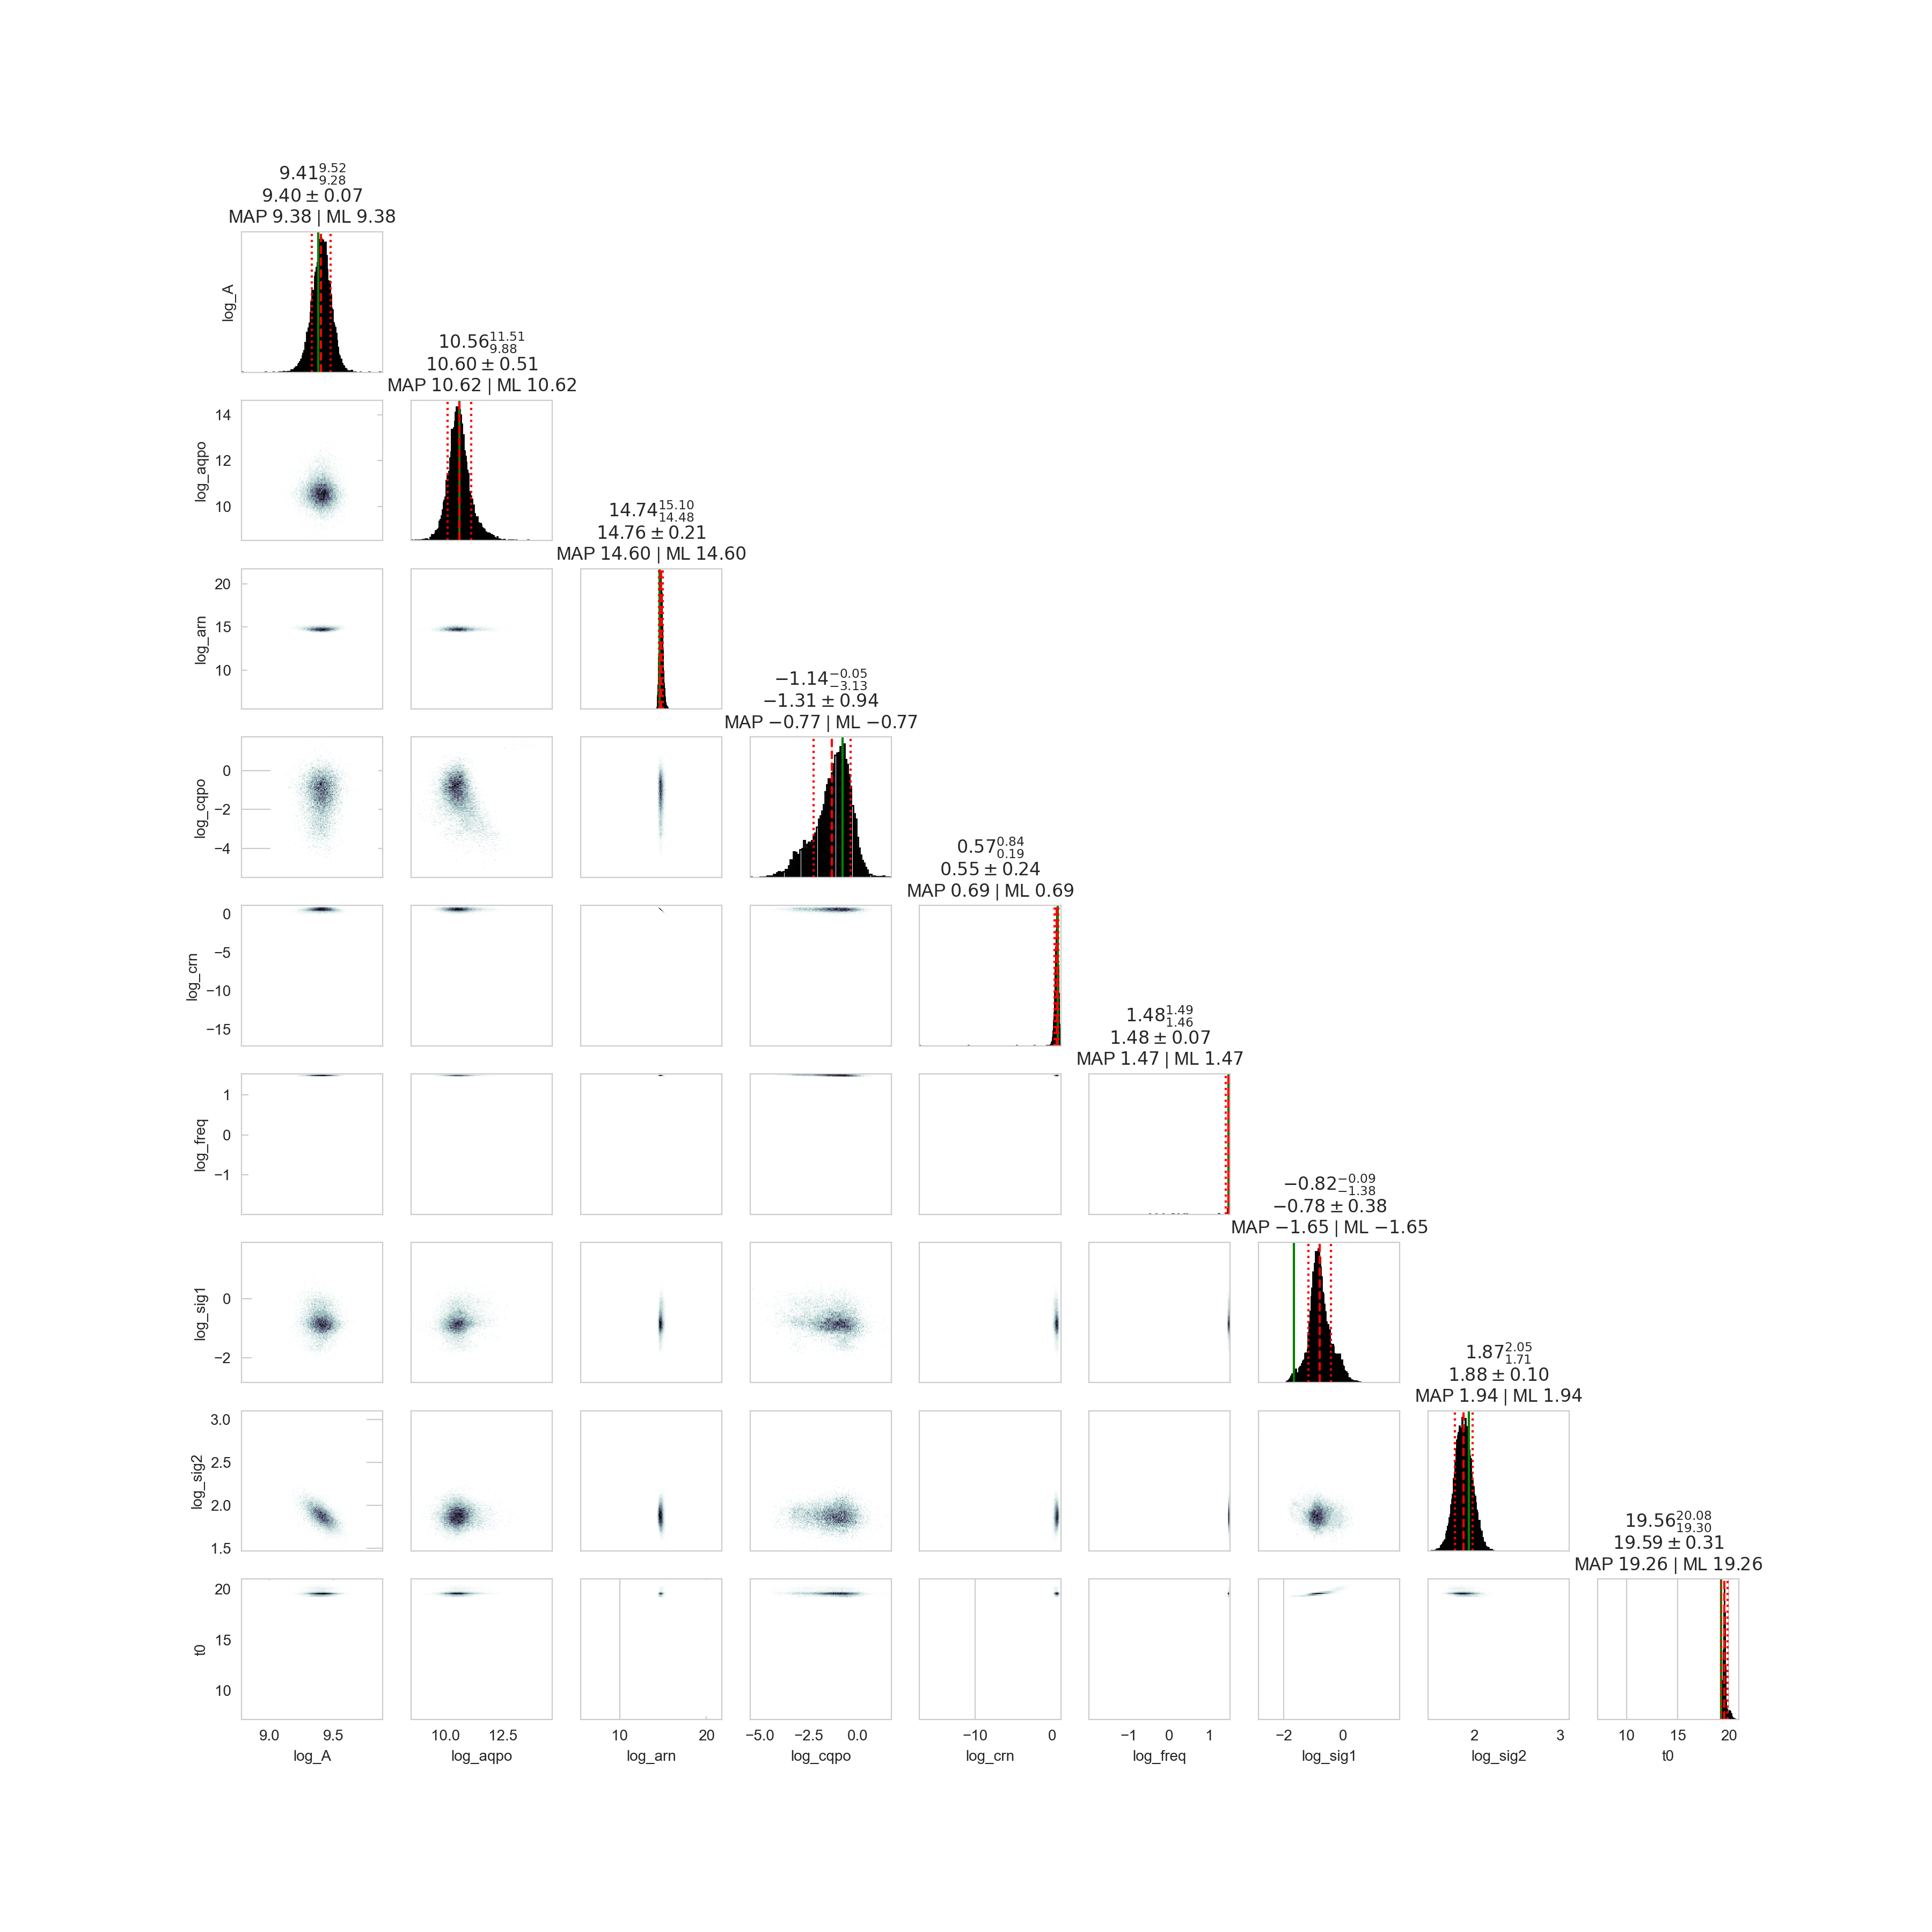

In [92]:
gpresult_qporn.plot_cornerplot()

<IPython.core.display.Javascript object>


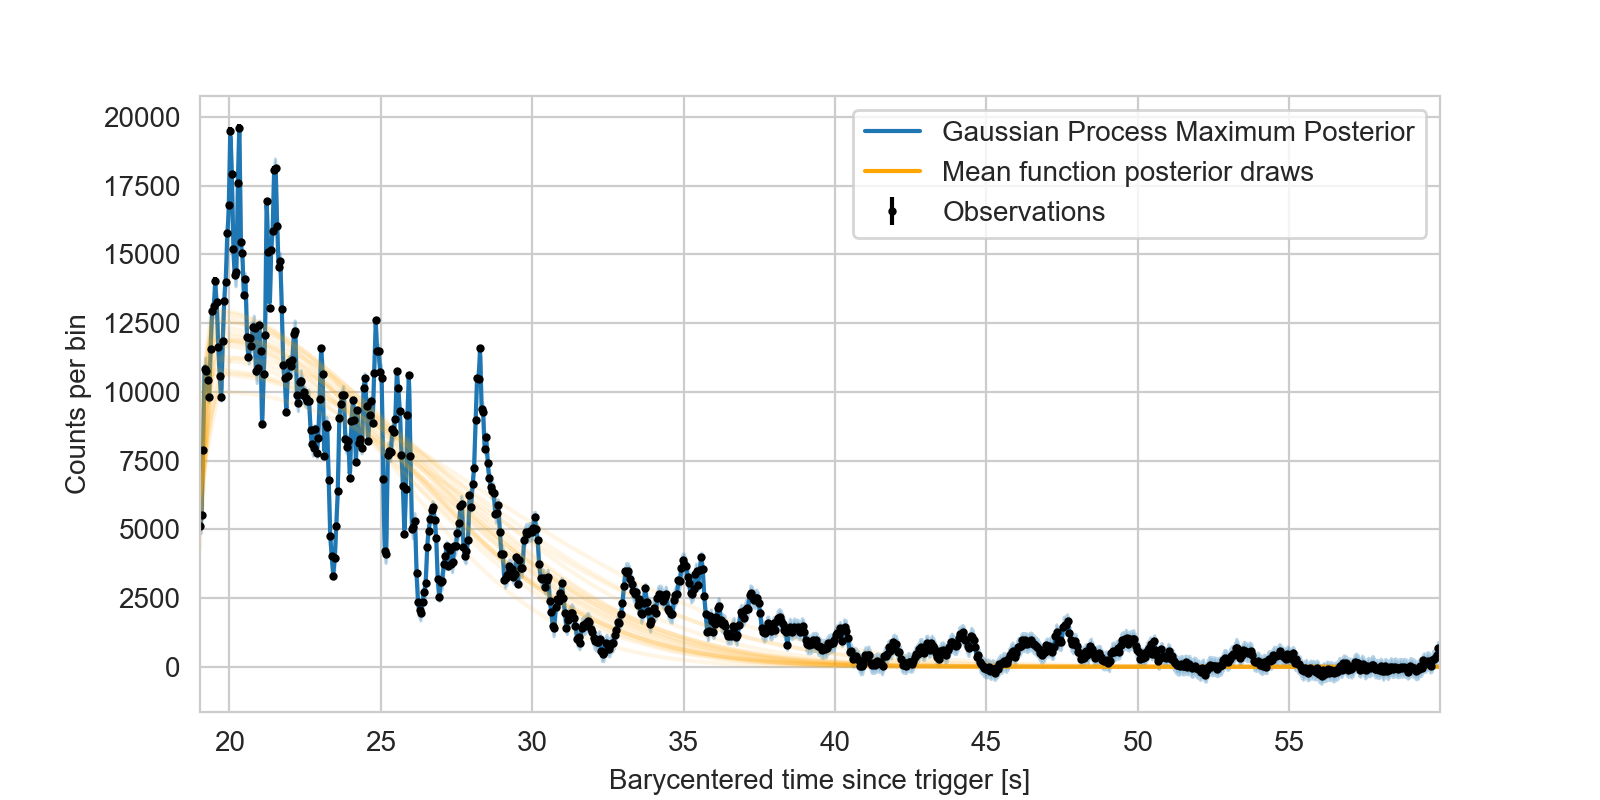

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc2, gpresult_qporn.results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc2.time[0], lc2.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [94]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1330)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [95]:
freq = np.exp(freq_resampled)
period = 1.0/freq

<IPython.core.display.Javascript object>


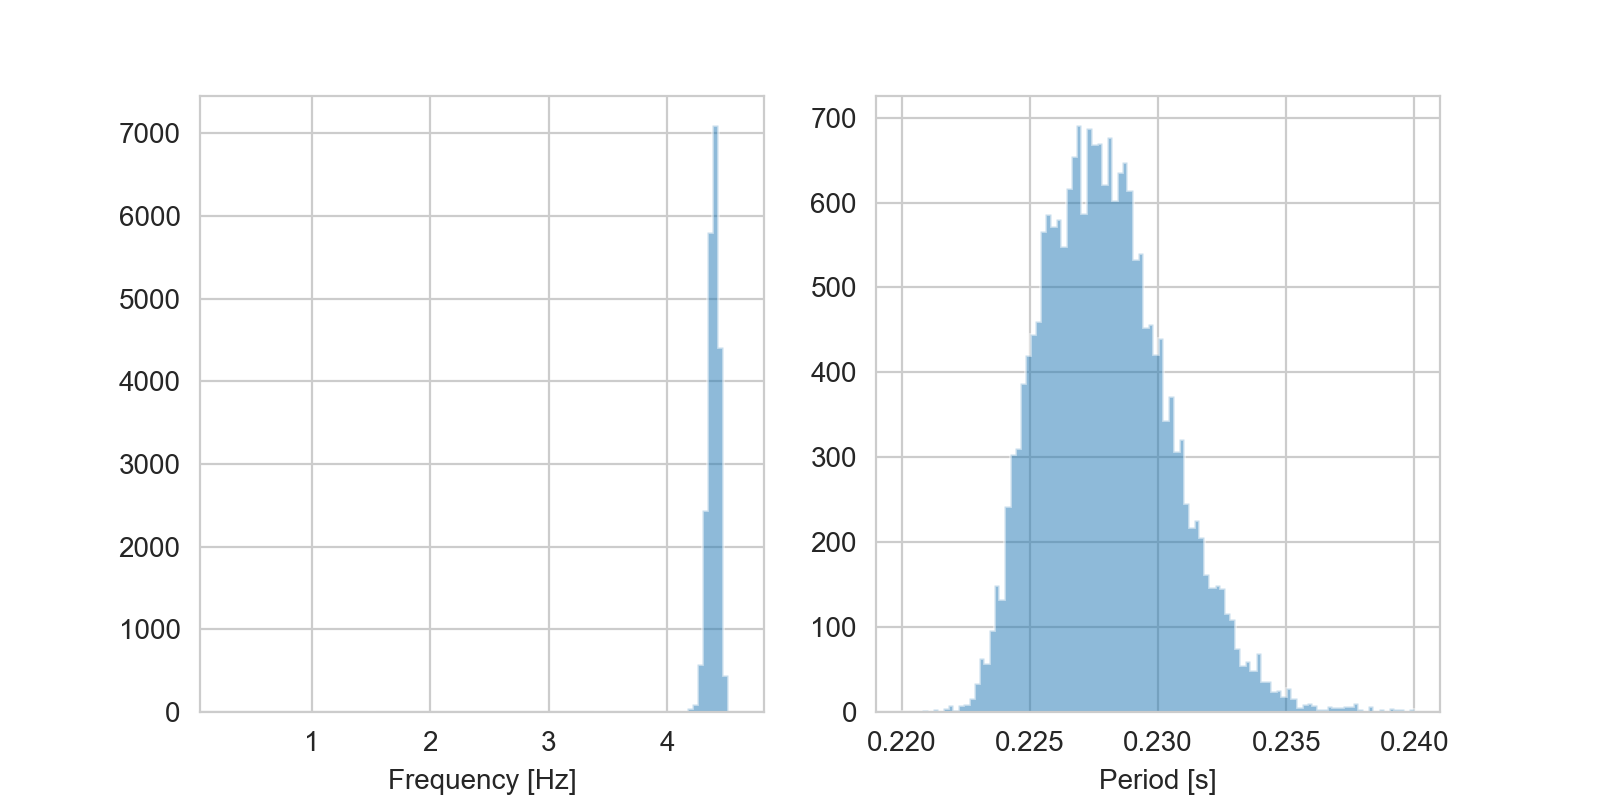

Text(0.5, 0, 'Period [s]')

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5, range=[0.22,0.24])
ax2.set_xlabel("Period [s]")
#ax2.set_xlim(0, 1)

In [84]:
import corner

# Split the Light Curve in 4

Let's see what happens when I split the light curve in 4:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.counts)

In [ ]:
split_idx1 = lc.time.searchsorted(7.6)
split_idx2 = lc.time.searchsorted(18.0)
split_idx3 = lc.time.searchsorted(19.0)
split_idx4 = lc.time.searchsorted(30.0)

lc1 = lc.truncate(start=0, stop=split_idx1)
lc2 = lc.truncate(start=split_idx1, stop=split_idx2)
lc3 = lc.truncate(start=split_idx3, stop=split_idx4)
lc4 = lc.truncate(start=split_idx4, stop=len(lc.time))

fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.plot(lc1.time, lc1.counts)
ax.plot(lc2.time, lc2.counts)
ax.plot(lc3.time, lc3.counts)
ax.plot(lc4.time, lc4.counts)

Okay, let's try to model this.

## Four-Split, LC1:

In [ ]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc1.time, counts = lc1.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc1)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
### SAVE THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc1_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)
    
res_rn = gpresult_rn.results

In [ ]:
### LOAD THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc1_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [ ]:
gpresult_rn.print_summary()

In [ ]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

In [ ]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc1, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc1.time[0], lc1.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### 4 split, lc1: red noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc1.time, counts = lc1.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc1)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2500)

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

In [ ]:
gpresult_qporn.get_evidence()

In [ ]:
with open(datadir+"intregal_drw_qpo_4split_lc1_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc1, gpresult_qporn.results, "QPO_plus_RN", mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc1.time[0], lc1.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1334)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

freq = np.exp(freq_resampled)
period = 1.0/freq


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - res_rn.log_Z_mean))

Okay, let's try to model this.

## Four-Split, LC2:

In [ ]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc2.time, counts = lc2.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc2)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
### SAVE THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc2_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)
    
res_rn = gpresult_rn.results

In [ ]:
### LOAD THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc2_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [ ]:
gpresult_rn.print_summary()

In [ ]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

In [ ]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc2, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc2.time[0], lc2.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### 4 split, lc2: red noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc2.time, counts = lc2.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc2)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

In [ ]:
gpresult_qporn.get_evidence()

In [ ]:
with open(datadir+"intregal_drw_qpo_4split_lc2_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc2, gpresult_qporn.results, "QPO_plus_RN", mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc1.time[0], lc1.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1334)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

freq = np.exp(freq_resampled)
period = 1.0/freq


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - res_rn.log_Z_mean))

Okay, let's try to model this.

## Four-Split, LC3:

In [ ]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc3.time, counts = lc3.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc3)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
### SAVE THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc3_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)
    
res_rn = gpresult_rn.results

In [ ]:
### LOAD THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc3_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [ ]:
gpresult_rn.print_summary()

In [ ]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

In [ ]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc3, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc3.time[0], lc3.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### 4 split, LC3: red noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc3.time, counts = lc3.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc3)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

In [ ]:
gpresult_qporn.get_evidence()

In [ ]:
with open(datadir+"intregal_drw_qpo_4split_lc3_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc3, gpresult_qporn.results, "QPO_plus_RN", mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc3.time[0], lc3.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1334)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

freq = np.exp(freq_resampled)
period = 1.0/freq


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - res_rn.log_Z_mean))

Okay, let's try to model this.

## Four-Split, LC4:

In [ ]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc4.time, counts = lc4.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc4)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
### SAVE THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc4_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)
    
res_rn = gpresult_rn.results

In [ ]:
### LOAD THE POSTERIOR
with open(datadir+"intregal_drw_4split_lc4_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [ ]:
gpresult_rn.print_summary()

In [ ]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

In [ ]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc4, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc4.time[0], lc4.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### 4 split, LC4: red noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = lc4.time, counts = lc4.counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc4)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - res_rn.log_Z_mean}")

In [ ]:
gpresult_qporn.get_evidence()

In [ ]:
with open(datadir+"intregal_drw_qpo_4split_lc4_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc4, gpresult_qporn.results, "QPO_plus_RN", mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc4.time[0], lc4.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1334)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

freq = np.exp(freq_resampled)
period = 1.0/freq


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - res_rn.log_Z_mean))